# Binary Classification Results for Multi-modal Approaches

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
import tensorflow as tf 
import tensorflow_addons as tfa

from pathlib import Path
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score, confusion_matrix, balanced_accuracy_score
from tensorflow.keras.layers import Input, LSTM, Dense, Flatten, TimeDistributed, Conv1D, BatchNormalization, MaxPooling1D, ConvLSTM1D, Bidirectional, Concatenate
from tensorflow.keras import Model
from tensorflow.keras.initializers import Constant
from keras.layers.advanced_activations import PReLU

## Methods for loading datasets and creating model architectures

In [3]:
def load_file(file):
    df = pd.read_csv(file, header=0)
    labels = df['pain']
    df = df.drop(columns=['pain'])
    df.drop(df.columns[-1], axis=1, inplace=True)
    return df, labels

def load_dataset(input_filepath, modality):
    feature_names = []
    root_dir = Path(os.path.abspath('')).parent
    data_dir = root_dir / 'data'
    train_filepath = data_dir / input_filepath / 'train' / modality
    test_filepath = data_dir / input_filepath / 'test' / modality
    # 1. Load train data
    X = list()
    y = list()
    for file in train_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            x, labels = load_file(file)
            if feature_names == []:
                feature_names = x.columns.values.tolist()
            x = x.to_numpy()
            X.append(x)
            if labels[0] != 'No Pain':
                y.append('Pain')
            else:
                y.append('No Pain')
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    X_train = X.reshape((len(X), 1, n_length, n_features))
    lb = LabelBinarizer()
    y_train = lb.fit_transform(y)
    # 2. Load test data
    X = list()
    y = list()
    for file in test_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            x, labels = load_file(file)
            x = x.to_numpy()
            X.append(x)
            if labels[0] != 'No Pain':
                y.append('Pain')
            else:
                y.append('No Pain')
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    X_test = X.reshape((len(X), 1, n_length, n_features))
    y_test = lb.transform(y)
    return X_train, X_test, y_train, y_test, feature_names, lb.inverse_transform(y_train)

def load_earlyfusion_dataset(input_filepath):
    root_dir = Path(os.path.abspath('')).parent
    data_dir = root_dir / 'data'
    body_train_filepath = data_dir / input_filepath / 'train' / 'skeleton'
    body_test_filepath = data_dir / input_filepath / 'test' / 'skeleton'
    face_train_filepath = data_dir / input_filepath / 'train' / 'AUs'
    face_test_filepath = data_dir / input_filepath / 'test' / 'AUs'
    head_train_filepath = data_dir / input_filepath / 'train' / 'pose'
    head_test_filepath = data_dir / input_filepath / 'test' / 'pose'
    # 1. Load train data
    X = list()
    y = list()
    for file in body_train_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            body_x, body_labels = load_file(file)
            has_equivalent_face_file = False
            for second_file in face_train_filepath.iterdir():
                if second_file.is_file() and second_file.name.endswith('.csv') and second_file.name == file.name:
                    # Concatenate features
                    face_x, face_labels = load_file(second_file)
                    head_x, head_labels = load_file(head_train_filepath / second_file.name)
                    full_X = np.concatenate((body_x, face_x), axis=1)
                    full_X = np.concatenate((full_X, head_x), axis=1)
                    body_x = body_x.to_numpy()
                    face_x = face_x.to_numpy()
                    head_x = head_x.to_numpy()
                    X.append(full_X)
                    y.append(body_labels[0])
                    has_equivalent_face_file = True
                    break
            if not has_equivalent_face_file:
                continue
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    X_train = X.reshape((len(X), 1, n_length, n_features))
    lb = LabelBinarizer()
    y_train = lb.fit_transform(y)
    # 2. Load test data
    X = list()
    y = list()
    for file in body_test_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            body_x, body_labels = load_file(file)
            body_x = body_x.to_numpy()
            has_equivalent_face_file = False
            for second_file in face_test_filepath.iterdir():
                if second_file.is_file() and second_file.name.endswith('.csv') and second_file.name == file.name:
                    # Concatenate features
                    face_x, face_labels = load_file(second_file)
                    head_x, head_labels = load_file(head_test_filepath / second_file.name)
                    face_x = face_x.to_numpy()
                    head_x = head_x.to_numpy()
                    full_X = np.concatenate((body_x, face_x), axis=1)
                    full_X = np.concatenate((full_X, head_x), axis=1)
                    X.append(full_X)
                    y.append(body_labels[0])
                    has_equivalent_face_file = True
                    break
            if not has_equivalent_face_file:
                continue
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    X_test = X.reshape((len(X), 1, n_length, n_features))
    y_test = lb.transform(y)
    return X_train, X_test, y_train, y_test

def load_latefusion_dataset(input_filepath, modality):
    root_dir = Path(os.path.abspath('')).parent
    data_dir = root_dir / 'data'
    train_filepath = data_dir / input_filepath / 'train' / modality
    test_filepath = data_dir / input_filepath / 'test' / modality
    # 1. Load train data
    X = list()
    y = list()
    for file in train_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            x, labels = load_file(file)
            if modality == 'skeleton':
                has_equivalent_face_file = False 
                for second_file in (data_dir / input_filepath / 'train' / 'AUs').iterdir():
                    if second_file.is_file() and second_file.name.endswith('.csv') and second_file.name == file.name:
                        has_equivalent_face_file = True
                        break
                if not has_equivalent_face_file:
                    continue
                else: 
                    x = x.to_numpy()
                    X.append(x)
                    y.append(labels[0])
            else:
                x = x.to_numpy()
                X.append(x)
                y.append(labels[0])
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    X_train = X.reshape((len(X), 1, n_length, n_features))
    lb = LabelBinarizer()
    y_train = lb.fit_transform(y)
    # 2. Load test data
    X = list()
    y = list()
    for file in test_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            x, labels = load_file(file)
            if modality == 'skeleton':
                has_equivalent_face_file = False 
                for second_file in (data_dir / input_filepath / 'test' / 'AUs').iterdir():
                    if second_file.is_file() and second_file.name.endswith('.csv') and second_file.name == file.name:
                        has_equivalent_face_file = True
                        break
                if not has_equivalent_face_file:
                    continue
                else: 
                    x = x.to_numpy()
                    X.append(x)
                    y.append(labels[0])
            else:
                x = x.to_numpy()
                X.append(x)
                y.append(labels[0])
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    X_test = X.reshape((len(X), 1, n_length, n_features))
    y_test = lb.transform(y)
    return X_train, X_test, y_train, y_test

In [23]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=50,
    restore_best_weights=True,
)

def train(model, X_train, y_train, X_val, y_val, epochs, batch_size):
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
    return history

def train_fusioned(model, body_X_train, face_X_train, head_X_train, y_train, body_X_val, face_X_val, head_X_val, y_val, epochs, batch_size):
    history = model.fit([body_X_train, face_X_train, head_X_train], y_train, validation_data=([body_X_val, face_X_val, head_X_val], y_val), 
                        epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
    return history

### CNN + Bidirectional LSTM Model

This combination was developed for visual time series prediction problems and is popular in both activity recognition and pain assessment areas.
Bidrectional LSTM runs the input in two ways (past to future and future to past) making it possible to preserve information both backwards and forwards. I included this layer type anticipating it could be suited for making the model understand context to assess any experience of pain. 

Additionally, bidrectional LSTM is used by [Bargshady et al.](https://pubmed.ncbi.nlm.nih.gov/34756219/) in an Ensemble combination of CNN+BiLSTM models for facial expressions modality. Their settings: 

- filters: 256
- dense: 4096

Several previous work has used CNN+LSTM models, for example:

- [Yang et al.](https://arxiv.org/abs/2105.08822) to encode appearance changes and physiological cues from videos. 

- [Salekin et al.](https://arxiv.org/abs/2012.02175). Combines three modalities with (late) decision fusion. CNN filters start at 64 and gradually increses by a factor of 2 until 512. Used a small kernel size of 3, and follow with a pooling layer. Dense: 512. LSTM: 16 with activation tanh and recurrent activation hard sigmoid (because of binary classification). 

- [Haque et al.](https://ieeexplore-ieee-org.proxy.lnu.se/document/8373837) extracts RGB, thermal, depth features from videos and test two fusion strategies (early fusion received highest performance). LSTM hidden states vary between 64 and 256.

- [Rodriguez et al.](https://ieeexplore-ieee-org.proxy.lnu.se/document/7849133). Trying to make an end-to-end framework using VGGFace architecture + LSTM.

In [14]:
def build_CNNLSTM(n_features, n_length, n_outputs):
    input = Input(shape=(1, n_length, n_features))
    conv1d_1 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='tanh'))(input)
    conv1d_2 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='tanh'))(conv1d_1)
    maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(conv1d_2)
    conv1d_3 = TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='tanh'))(maxpool_1)
    conv1d_4 = TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='tanh'))(conv1d_3)
    maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(conv1d_4)
    flatten = TimeDistributed(Flatten())(maxpool_2)
    lstm_1 = Bidirectional(LSTM(100, return_sequences=True))(flatten)
    lstm_2 = Bidirectional(LSTM(100))(lstm_1)
    dense_1 = Dense(256, activation='tanh')(lstm_2)
    dense_2 = Dense(512, activation='tanh')(dense_1)
    output = Dense(units=n_outputs, activation='sigmoid')(dense_2)
    model = Model(inputs=input, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
    return model

def build_fusioned_CNNLSTM(body_features, face_features, head_features, n_length, n_outputs):
    input_1 = Input(shape=(1, n_length, body_features))
    conv1d_1 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='tanh'))(input_1)
    conv1d_11 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='tanh'))(conv1d_1)
    bn_1 = TimeDistributed(BatchNormalization())(conv1d_11)
    maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn_1)
    conv1d_111 = TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='tanh'))(maxpool_1)
    conv1d_1111 = TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='tanh'))(conv1d_111)
    bn_11 = TimeDistributed(BatchNormalization())(conv1d_1111)
    maxpool_11 = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn_11)
    flatten_1 = TimeDistributed(Flatten())(maxpool_11)
    lstm_1 = Bidirectional(LSTM(100, return_sequences=True))(flatten_1)
    lstm_11 = Bidirectional(LSTM(100))(lstm_1)
    dense_1 = Dense(256, activation='tanh')(lstm_11)
    dense_11 = Dense(256, activation='tanh')(dense_1)

    input_2 = Input(shape=(1, n_length, face_features))
    conv1d_2 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='tanh'))(input_2)
    conv1d_22 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='tanh'))(conv1d_2)
    bn_2 = TimeDistributed(BatchNormalization())(conv1d_22)
    maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn_2)
    conv1d_222 = TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='tanh'))(maxpool_2)
    conv1d_2222 = TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='tanh'))(conv1d_222)
    bn_22 = TimeDistributed(BatchNormalization())(conv1d_2222)
    maxpool_22 = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn_22)
    flatten_2 = TimeDistributed(Flatten())(maxpool_22)
    lstm_2 = Bidirectional(LSTM(100, return_sequences=True))(flatten_2)
    lstm_22 = Bidirectional(LSTM(100))(lstm_2)
    dense_2 = Dense(256, activation='tanh')(lstm_22)
    dense_22 = Dense(256, activation='tanh')(dense_2)

    input_3 = Input(shape=(1, n_length, head_features))
    conv1d_3 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='tanh'))(input_3)
    conv1d_33 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='tanh'))(conv1d_3)
    bn_3 = TimeDistributed(BatchNormalization())(conv1d_33)
    maxpool_3 = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn_3)
    conv1d_333 = TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='tanh'))(maxpool_3)
    conv1d_3333 = TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='tanh'))(conv1d_333)
    bn_33 = TimeDistributed(BatchNormalization())(conv1d_3333)
    maxpool_33 = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn_33)
    flatten_3 = TimeDistributed(Flatten())(maxpool_33)
    lstm_3 = Bidirectional(LSTM(100, return_sequences=True))(flatten_3)
    lstm_33 = Bidirectional(LSTM(100))(lstm_3)
    dense_3 = Dense(256, activation='tanh')(lstm_33)
    dense_33 = Dense(256, activation='tanh')(dense_3)

    concat = Concatenate()([dense_11, dense_22, dense_33])
    output = Dense(units=n_outputs, activation='sigmoid')(concat)
    model = Model(inputs=[input_1, input_2, input_3], outputs=[output])
    model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
    return model

### ConvLSTM

In [42]:
def build_convLSTM(n_features, n_length, n_outputs):
    input = Input(shape=(1, n_length, n_features))
    convlstm_1 = Bidirectional(ConvLSTM1D(filters=84, kernel_size=(3), activation='tanh', return_sequences=True))(input)
    convlstm_2 = Bidirectional(ConvLSTM1D(filters=84, kernel_size=(3), activation='tanh'))(convlstm_1)
    flatten = Flatten()(convlstm_2)
    dense_1 = Dense(256, activation='tanh')(flatten)
    dense_2 = Dense(256, activation='tanh')(dense_1)
    output = Dense(units=n_outputs, activation='sigmoid')(dense_2)
    model = Model(inputs=input, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
    return model

def build_fusioned_convLSTM(body_features, face_features, head_features, n_length, n_outputs):
    input_1 = Input(shape=(1, n_length, body_features))
    convlstm_1 = Bidirectional(ConvLSTM1D(filters=84, kernel_size=(3), activation='tanh', return_sequences=True))(input_1)
    convlstm_11 = Bidirectional(ConvLSTM1D(filters=84, kernel_size=(3), activation='tanh'))(convlstm_1)
    flatten_1 = Flatten()(convlstm_11)
    dense_1 = Dense(256, activation='tanh')(flatten_1)
    dense_11 = Dense(256, activation='tanh')(dense_1)

    input_2 = Input(shape=(1, n_length, face_features))
    convlstm_2 = Bidirectional(ConvLSTM1D(filters=84, kernel_size=(3), activation='tanh', return_sequences=True))(input_2)
    convlstm_22 = Bidirectional(ConvLSTM1D(filters=84, kernel_size=(3), activation='tanh'))(convlstm_2)
    flatten_2 = Flatten()(convlstm_22)
    dense_2 = Dense(256, activation='tanh')(flatten_2)
    dense_22 = Dense(256, activation='tanh')(dense_2)

    input_3 = Input(shape=(1, n_length, head_features))
    convlstm_3 = Bidirectional(ConvLSTM1D(filters=84, kernel_size=(3), activation='tanh', return_sequences=True))(input_3)
    convlstm_33 = Bidirectional(ConvLSTM1D(filters=84, kernel_size=(3), activation='tanh'))(convlstm_3)
    flatten_3 = Flatten()(convlstm_33)
    dense_3 = Dense(256, activation='tanh')(flatten_3)
    dense_33 = Dense(256, activation='tanh')(dense_3)

    concat = Concatenate()([dense_11, dense_22, dense_33])
    output = Dense(units=n_outputs, activation='sigmoid')(concat)
    model = Model(inputs=[input_1, input_2, input_3], outputs=[output])
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
    return model

### RCNN (Recurrent CNN) Model

A network that has both convolutional and recurrent convolutional layers, or adding recurrent connections within every convolutional layer of a feed-forward CNN.

Additionally, RCNN is used by [Zhou et al.](https://ieeexplore-ieee-org.proxy.lnu.se/document/7789681) with video input for pain intensity prediction using PSPI.

In [7]:
def build_RCNN(n_features, n_length, n_outputs):
   input = Input(shape=(1, n_length, n_features))
   conv1d_1 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input)
   bn_1 = TimeDistributed(BatchNormalization())(conv1d_1)
   maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn_1)
   conv1d_2 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(maxpool_1)
   bn_2 = TimeDistributed(BatchNormalization())(conv1d_2)
   maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn_2)
   flatten = Flatten()(maxpool_2)
   dense_1 = Dense(256)(flatten)
   dense_2 = Dense(256)(dense_1)
   output = Dense(units=n_outputs, activation='sigmoid')(dense_2)
   model = Model(inputs=input, outputs=output)
   model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
   return model


def build_fusioned_RCNN(body_features, face_features, head_features, n_length, n_outputs):
   input_1 = Input(shape=(1, n_length, body_features))
   conv1d_1 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input_1)
   conv1d_11 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(conv1d_1)
   bn_1 = TimeDistributed(BatchNormalization())(conv1d_11)
   maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn_1)
   conv1d_111 = TimeDistributed(Conv1D(filters=128, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(maxpool_1)
   conv1d_1111 = TimeDistributed(Conv1D(filters=128, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(conv1d_111)
   bn_11 = TimeDistributed(BatchNormalization())(conv1d_1111)
   maxpool_11 = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn_11)
   flatten_1 = Flatten()(maxpool_11)
   dense_1 = Dense(256, activation='relu')(flatten_1)
   dense_11 = Dense(256, activation='relu')(dense_1)

   input_2 = Input(shape=(1, n_length, face_features))
   conv1d_2 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input_2)
   conv1d_22 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(conv1d_2)
   bn_2 = TimeDistributed(BatchNormalization())(conv1d_22)
   maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn_2)
   conv1d_222 = TimeDistributed(Conv1D(filters=128, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(maxpool_2)
   conv1d_2222 = TimeDistributed(Conv1D(filters=128, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(conv1d_222)
   bn_22 = TimeDistributed(BatchNormalization())(conv1d_2222)
   maxpool_22 = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn_22)
   flatten_2 = Flatten()(maxpool_22)
   dense_2 = Dense(256, activation='relu')(flatten_2)
   dense_22 = Dense(256, activation='relu')(dense_2)

   input_3 = Input(shape=(1, n_length, head_features))
   conv1d_3 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input_3)
   conv1d_33 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(conv1d_3)
   bn_3 = TimeDistributed(BatchNormalization())(conv1d_33)
   maxpool_3 = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn_3)
   conv1d_333 = TimeDistributed(Conv1D(filters=128, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(maxpool_3)
   conv1d_3333 = TimeDistributed(Conv1D(filters=128, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(conv1d_333)
   bn_33 = TimeDistributed(BatchNormalization())(conv1d_3333)
   maxpool_33 = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn_33)
   flatten_3 = Flatten()(maxpool_33)
   dense_3 = Dense(256, activation='relu')(flatten_3)
   dense_33 = Dense(256, activation='relu')(dense_3)

   concat = Concatenate()([dense_11, dense_22, dense_33])
   output = Dense(units=n_outputs, activation='sigmoid')(concat)
   model = Model(inputs=[input_1, input_2, input_3], outputs=[output])
   model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
   return model

### Dirichlet Markov Ensemble with soft voting

The Dirichlet ensemble weights the ensemble members based on validation set performance. The weight optimization search is performed with randomized search based on the dirichlet distribution. 
    
Soft voting involves summing the predicted probability scores for each class label and predicting the class label with the largest probability.

In [8]:
class KerasMember():
    def __init__(self, name=None, keras_model=None, train_batches=None,
                 val_batches=None, submission_probs=None, keras_modelpath=None,
                 keras_kwargs={}):
        assert(name is not None)
        self.name = name
        self.model = keras_model
        self.submission_probs = submission_probs
        # Initialize Params
        self.val_probs = None
        self.train_probs = None
        self.val_classes = None
        self.train_classes = None
        if (keras_model is None) and (keras_modelpath is not None):
            self.load_kerasmodel(self.keras_modelpath, self.keras_kwargs)
        if train_batches is not None:
            self._calculate_train_predictions(train_batches)
        if val_batches is not None:
            self._calculate_val_predictions(val_batches)

    def _test_datatuple(self, datatuple):
        assert(len(datatuple) == 2)
        assert(datatuple[0].shape[0] == datatuple[1].shape[0])

    def _calculate_predictions(self, batches):
        if hasattr(batches, 'shuffle'):
            batches.reset()
            batches.shuffle = False
        if type(batches) is tuple:
            self._test_datatuple(batches)
            return self.model.predict(batches[0])
        return self.model.predict_generator(
            batches, steps=(batches.n // batches.batch_size) + 1, verbose=1)

    def _calculate_val_predictions(self, val_batches):
        if type(val_batches) is tuple:
            self.val_classes = val_batches[1]
        elif hasattr(val_batches, 'classes'):
            self.val_classes = np.array(val_batches.classes)
        elif hasattr(val_batches, 'y'):
            self.val_classes = np.array(val_batches.y)
        else:
            raise ValueError("No known class in data batch")
        self.val_probs = self._calculate_predictions(val_batches)
        return self.val_probs

    def _calculate_train_predictions(self, train_batches):
        if type(train_batches) is tuple:
            self.train_classes = train_batches[1]
        elif hasattr(train_batches, 'classes'):
            self.train_classes = np.array(train_batches.classes)
        elif hasattr(train_batches, 'y'):
            self.train_classes = np.array(train_batches.y)
        else:
            raise ValueError("No known class in data batch")
        self.train_probs = self._calculate_predictions(train_batches)
        return self.train_probs


In [9]:
def _calculate_metric(y_true, y_pred, metric=None):
    if metric is None:
        metric = roc_auc_score
    y_t = y_true
    y_p = y_pred
    if metric == roc_auc_score:
        return metric(y_t, y_p, multi_class='ovo')
    if y_true.ndim > 1:
        y_t = np.argmax(y_true, axis=1)
    if y_pred.ndim > 1:
        y_p = np.argmax(y_pred, axis=1)
    if metric is precision_recall_fscore_support:
        return precision_recall_fscore_support(y_t, y_p, average='macro')
    if metric is balanced_accuracy_score:
        return balanced_accuracy_score(y_t, y_p)
    return metric(y_t, y_p)

In [10]:
class DirichletEnsemble():
    def __init__(self, N=10000, metric=None, maximize=True):
        self.n = N
        self.metric = metric
        if metric is None:
            self.metric = roc_auc_score
        self.maximize = maximize
        # Initialize Parameters:
        self.members = []
        self.bestweights = []
        self.probabilities = None
        self._nmembers = 0
        self.bestscore = float("-inf") if maximize else float("inf")
        self.accuracy = None
        self.precision = None
        self.recall = None
        self.f1 = None
        self.fitted = False

    def add_members(self, members):
        for member in members:
            self.add_member(member)

    def add_member(self, member):
        self.members.append(member)
        self._nmembers += 1

    def fit(self, verbose=False):
        assert(len(self.members) > 1)
        val_classes = self.members[0].val_classes
        best_ensemble_score = float("-inf") if self.maximize else float("inf")
        best_ensemble_accuracy = 0
        best_ensemble_balanced_acc = 0
        best_ensemble_p = 0
        best_ensemble_r = 0
        best_ensemble_f1 = 0
        rsbest = None
        for i in range(self.n):
            rs = np.random.dirichlet(np.ones(self._nmembers), size=1)[0]
            preds = np.sum(np.array([self.members[i].val_probs * rs[i]
                                     for i in range(self._nmembers)]), axis=0)
            ensemble_score = _calculate_metric(val_classes, preds)
            ensemble_accuracy = _calculate_metric(val_classes, preds, accuracy_score)
            ensemble_balanced_acc = _calculate_metric(val_classes, preds, balanced_accuracy_score)
            ensemble_prf1 = _calculate_metric(val_classes, preds, precision_recall_fscore_support)
            ensemble_p = ensemble_prf1[0]
            ensemble_r = ensemble_prf1[1]
            ensemble_f1 = ensemble_prf1[2]
            max_flag = self.maximize and ensemble_score > best_ensemble_score
            min_flag = not(
                self.maximize) and ensemble_score < best_ensemble_score
            if max_flag or min_flag:
                if verbose:
                    print(ensemble_score, i, rs) 
                best_ensemble_score = ensemble_score
                rsbest = rs
            if ensemble_accuracy > best_ensemble_accuracy:
                if verbose:
                    print(ensemble_accuracy, i, rs) 
                best_ensemble_accuracy = ensemble_accuracy
            if ensemble_balanced_acc > best_ensemble_balanced_acc:
                if verbose:
                    print(ensemble_balanced_acc, i, rs) 
                best_ensemble_balanced_acc = ensemble_balanced_acc
            if ensemble_p > best_ensemble_p:
                if verbose:
                    print(ensemble_p, i, rs) 
                best_ensemble_p = ensemble_p
            if ensemble_r > best_ensemble_r:
                if verbose:
                    print(ensemble_r, i, rs) 
                best_ensemble_r = ensemble_r
            if ensemble_f1 > best_ensemble_f1:
                if verbose:
                    print(ensemble_f1, i, rs) 
                best_ensemble_f1 = ensemble_f1
        self.bestweights = rsbest
        self.bestscore = best_ensemble_score
        self.accuracy = best_ensemble_accuracy
        self.balanced_acc = best_ensemble_balanced_acc
        self.precision = best_ensemble_p
        self.recall = best_ensemble_r
        self.f1 = best_ensemble_f1

    def predict(self):
        self.probabilities = np.sum(np.array([self.bestweights[i] *
                                              self.members[i].submission_probs
                                              for i in range(self._nmembers)]),
                                    axis=0)
        return self.probabilities
        
    def describe(self):
        for i in range(self._nmembers):
            member = self.members[i]
            text = member.name + " (weight: {:1.4f})".format(self.bestweights[i])
            print(text)
        print("\nAccuracy: {:1.2f}% \nBalanced Accuracy: {:1.2f}% \nROC/AUC: {:1.2f} \nPrecision: {:1.2f} \nRecall: {:1.2f} \nF1 score: {:1.2f}".format(
            self.accuracy * 100, self.balanced_acc * 100, self.bestscore, self.precision, self.recall, self.f1))
        return

### KFold CV

In [11]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
epochs, batch_size = 100, 64

## 1. Uni-modal approaches

Training the different model architectures on single modalities (skeleton vs action units). 

### About the data

In [15]:
full_body_X_train, full_body_X_test, full_body_y_train, full_body_y_test, body_feature_names, classes = load_dataset('processed', 'skeleton')
full_body_X = full_body_X_train.copy()
full_body_y = full_body_y_train.copy()

print(full_body_X_train.shape, full_body_y_train.shape)
print(full_body_X_test.shape, full_body_y_test.shape)

n_length, body_features, body_outputs = full_body_X_train.shape[2], full_body_X_train.shape[-1], full_body_y_test.shape[1]

(791, 1, 350, 38) (791, 1)
(266, 1, 350, 38) (266, 1)


In [16]:
tmp = pd.DataFrame(classes)
classes = tmp.value_counts()
classes

No Pain    403
Pain       388
dtype: int64

### 1.1 Body modality (skeleton) models

#### Train CNN+LSTM

In [21]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []

Epoch 1/100
10/10 - 10s - loss: 0.6918 - accuracy: 0.5174 - auc_1: 0.5506 - precision_1: 0.5145 - recall_1: 0.4537 - f1_score: 0.6624 - val_loss: 0.6822 - val_accuracy: 0.5472 - val_auc_1: 0.6394 - val_precision_1: 0.5126 - val_recall_1: 0.8133 - val_f1_score: 0.6410 - 10s/epoch - 978ms/step
Epoch 2/100
10/10 - 3s - loss: 0.6650 - accuracy: 0.5949 - auc_1: 0.6373 - precision_1: 0.5953 - recall_1: 0.5687 - f1_score: 0.6624 - val_loss: 0.6642 - val_accuracy: 0.6164 - val_auc_1: 0.6463 - val_precision_1: 0.5897 - val_recall_1: 0.6133 - val_f1_score: 0.6410 - 3s/epoch - 331ms/step
Epoch 3/100
10/10 - 3s - loss: 0.6426 - accuracy: 0.6345 - auc_1: 0.6795 - precision_1: 0.6464 - recall_1: 0.5783 - f1_score: 0.6624 - val_loss: 0.6651 - val_accuracy: 0.6164 - val_auc_1: 0.6565 - val_precision_1: 0.5814 - val_recall_1: 0.6667 - val_f1_score: 0.6410 - 3s/epoch - 287ms/step
Epoch 4/100
10/10 - 3s - loss: 0.6272 - accuracy: 0.6472 - auc_1: 0.7097 - precision_1: 0.6541 - recall_1: 0.6102 - f1_score:

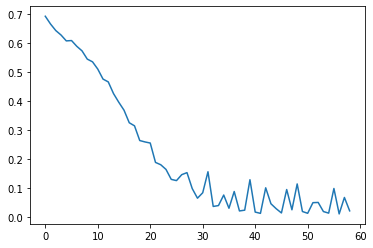

Epoch 1/100
10/10 - 10s - loss: 0.6910 - accuracy: 0.5308 - auc_2: 0.5528 - precision_2: 0.5125 - recall_2: 0.4737 - f1_score: 0.6489 - val_loss: 0.6876 - val_accuracy: 0.6139 - val_auc_2: 0.6120 - val_precision_2: 0.6533 - val_recall_2: 0.5833 - val_f1_score: 0.6942 - 10s/epoch - 959ms/step
Epoch 2/100
10/10 - 3s - loss: 0.6787 - accuracy: 0.5829 - auc_2: 0.6033 - precision_2: 0.5680 - recall_2: 0.5493 - f1_score: 0.6489 - val_loss: 0.7148 - val_accuracy: 0.5253 - val_auc_2: 0.6175 - val_precision_2: 0.7143 - val_recall_2: 0.1786 - val_f1_score: 0.6942 - 3s/epoch - 274ms/step
Epoch 3/100
10/10 - 3s - loss: 0.6654 - accuracy: 0.6130 - auc_2: 0.6323 - precision_2: 0.6007 - recall_2: 0.5789 - f1_score: 0.6489 - val_loss: 0.6548 - val_accuracy: 0.6203 - val_auc_2: 0.6835 - val_precision_2: 0.7069 - val_recall_2: 0.4881 - val_f1_score: 0.6942 - 3s/epoch - 272ms/step
Epoch 4/100
10/10 - 3s - loss: 0.6411 - accuracy: 0.6414 - auc_2: 0.6828 - precision_2: 0.6262 - recall_2: 0.6283 - f1_score:

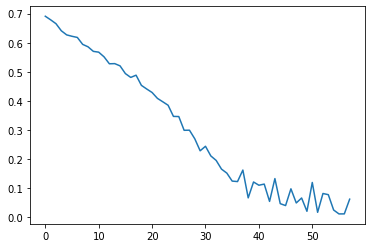

Epoch 1/100
10/10 - 9s - loss: 0.6962 - accuracy: 0.4992 - auc_3: 0.5237 - precision_3: 0.5000 - recall_3: 0.3596 - f1_score: 0.6674 - val_loss: 0.6766 - val_accuracy: 0.5823 - val_auc_3: 0.6298 - val_precision_3: 0.7273 - val_recall_3: 0.1127 - val_f1_score: 0.6201 - 9s/epoch - 934ms/step
Epoch 2/100
10/10 - 3s - loss: 0.6723 - accuracy: 0.5956 - auc_3: 0.6207 - precision_3: 0.6134 - recall_3: 0.5205 - f1_score: 0.6674 - val_loss: 0.6590 - val_accuracy: 0.6329 - val_auc_3: 0.6632 - val_precision_3: 0.5823 - val_recall_3: 0.6479 - val_f1_score: 0.6201 - 3s/epoch - 280ms/step
Epoch 3/100
10/10 - 3s - loss: 0.6379 - accuracy: 0.6635 - auc_3: 0.6893 - precision_3: 0.6733 - recall_3: 0.6372 - f1_score: 0.6674 - val_loss: 0.6336 - val_accuracy: 0.6329 - val_auc_3: 0.6789 - val_precision_3: 0.6140 - val_recall_3: 0.4930 - val_f1_score: 0.6201 - 3s/epoch - 286ms/step
Epoch 4/100
10/10 - 3s - loss: 0.6218 - accuracy: 0.6619 - auc_3: 0.7137 - precision_3: 0.6678 - recall_3: 0.6467 - f1_score: 0

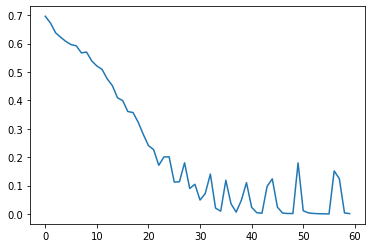

Epoch 1/100
10/10 - 10s - loss: 0.6917 - accuracy: 0.5324 - auc_4: 0.5492 - precision_4: 0.5317 - recall_4: 0.3528 - f1_score: 0.6561 - val_loss: 0.6594 - val_accuracy: 0.6392 - val_auc_4: 0.7125 - val_precision_4: 0.6000 - val_recall_4: 0.8354 - val_f1_score: 0.6667 - 10s/epoch - 959ms/step
Epoch 2/100
10/10 - 3s - loss: 0.6644 - accuracy: 0.6003 - auc_4: 0.6396 - precision_4: 0.5892 - recall_4: 0.5987 - f1_score: 0.6561 - val_loss: 0.6245 - val_accuracy: 0.6772 - val_auc_4: 0.7219 - val_precision_4: 0.6892 - val_recall_4: 0.6456 - val_f1_score: 0.6667 - 3s/epoch - 287ms/step
Epoch 3/100
10/10 - 3s - loss: 0.6383 - accuracy: 0.6556 - auc_4: 0.6823 - precision_4: 0.6757 - recall_4: 0.5663 - f1_score: 0.6561 - val_loss: 0.6227 - val_accuracy: 0.6582 - val_auc_4: 0.7132 - val_precision_4: 0.6667 - val_recall_4: 0.6329 - val_f1_score: 0.6667 - 3s/epoch - 297ms/step
Epoch 4/100
10/10 - 3s - loss: 0.6260 - accuracy: 0.6445 - auc_4: 0.7057 - precision_4: 0.6511 - recall_4: 0.5858 - f1_score:

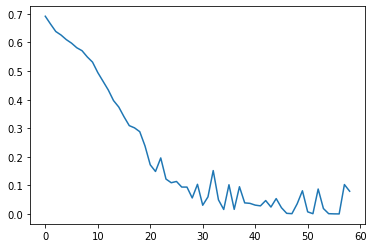

Epoch 1/100
10/10 - 10s - loss: 0.6898 - accuracy: 0.5371 - auc_5: 0.5660 - precision_5: 0.5301 - recall_5: 0.4563 - f1_score: 0.6561 - val_loss: 0.6672 - val_accuracy: 0.6139 - val_auc_5: 0.6299 - val_precision_5: 0.6452 - val_recall_5: 0.5063 - val_f1_score: 0.6667 - 10s/epoch - 963ms/step
Epoch 2/100
10/10 - 3s - loss: 0.6555 - accuracy: 0.6398 - auc_5: 0.6672 - precision_5: 0.6431 - recall_5: 0.5890 - f1_score: 0.6561 - val_loss: 0.6390 - val_accuracy: 0.6329 - val_auc_5: 0.7107 - val_precision_5: 0.6780 - val_recall_5: 0.5063 - val_f1_score: 0.6667 - 3s/epoch - 283ms/step
Epoch 3/100
10/10 - 3s - loss: 0.6300 - accuracy: 0.6572 - auc_5: 0.6959 - precision_5: 0.6797 - recall_5: 0.5631 - f1_score: 0.6561 - val_loss: 0.6399 - val_accuracy: 0.6266 - val_auc_5: 0.6872 - val_precision_5: 0.6351 - val_recall_5: 0.5949 - val_f1_score: 0.6667 - 3s/epoch - 291ms/step
Epoch 4/100
10/10 - 3s - loss: 0.6032 - accuracy: 0.6856 - auc_5: 0.7371 - precision_5: 0.6964 - recall_5: 0.6311 - f1_score:

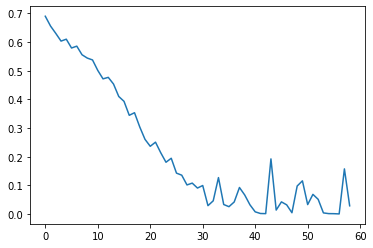

In [24]:
body_cnnlstm_model_path = Path(os.path.abspath('')).parent / 'models' / 'saved' / 'body_cnnlstm.h5'
val_accuracy = 0.0

for train_index, val_index in kf.split(full_body_X):
    X_train, X_val = full_body_X[train_index], full_body_X[val_index]
    y_train, y_val = full_body_y[train_index], full_body_y[val_index]
    body_cnnlstm = build_CNNLSTM(body_features, n_length, body_outputs)
    history = train(body_cnnlstm, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        body_cnnlstm.save(body_cnnlstm_model_path)

In [25]:
body_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
body_cnnlstm_train_results

{'Accuracy': 0.9857789993286132,
 'ROC/AUC': 0.9981280922889709,
 'Precision': 0.986331307888031,
 'Recall': 0.9844080448150635,
 'F1-score': 0.6581567287445068}

In [26]:
body_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
body_cnnlstm_val_results

{'Accuracy': 0.6662208437919617,
 'ROC/AUC': 0.7256466746330261,
 'Precision': 0.6543288707733155,
 'Recall': 0.685341763496399,
 'F1-score': 0.6577322602272033}

#### Train ConvLSTM

In [36]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []

In [43]:
body_convlstm_model_path = Path(os.path.abspath('')).parent / 'models' / 'saved' / 'body_convlstm.h5'
val_accuracy = 0.0

for train_index, val_index in kf.split(full_body_X):
    X_train, X_val = full_body_X[train_index], full_body_X[val_index]
    y_train, y_val = full_body_y[train_index], full_body_y[val_index]
    body_convLSTM = build_convLSTM(body_features, n_length, body_outputs)
    history = train(body_convLSTM, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        body_convLSTM.save(body_convlstm_model_path)

Epoch 1/100
10/10 - 21s - loss: 0.7767 - accuracy: 0.5902 - auc_12: 0.6025 - precision_12: 0.5894 - recall_12: 0.5687 - f1_score: 0.6624 - val_loss: 0.7019 - val_accuracy: 0.6101 - val_auc_12: 0.6573 - val_precision_12: 0.5575 - val_recall_12: 0.8400 - val_f1_score: 0.6410 - 21s/epoch - 2s/step
Epoch 2/100
10/10 - 9s - loss: 0.6416 - accuracy: 0.6361 - auc_12: 0.6899 - precision_12: 0.6203 - recall_12: 0.6837 - f1_score: 0.6624 - val_loss: 0.6777 - val_accuracy: 0.6038 - val_auc_12: 0.6523 - val_precision_12: 0.6765 - val_recall_12: 0.3067 - val_f1_score: 0.6410 - 9s/epoch - 941ms/step
Epoch 3/100
10/10 - 9s - loss: 0.6111 - accuracy: 0.6741 - auc_12: 0.7318 - precision_12: 0.6607 - recall_12: 0.7029 - f1_score: 0.6624 - val_loss: 0.6502 - val_accuracy: 0.5849 - val_auc_12: 0.6717 - val_precision_12: 0.5818 - val_recall_12: 0.4267 - val_f1_score: 0.6410 - 9s/epoch - 910ms/step
Epoch 4/100
10/10 - 10s - loss: 0.5867 - accuracy: 0.6915 - auc_12: 0.7662 - precision_12: 0.7287 - recall_12:

In [40]:
body_convlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
body_convlstm_train_results

{'Accuracy': 0.48324984312057495,
 'ROC/AUC': 0.4894727408885956,
 'Precision': 0.48125860691070554,
 'Recall': 0.7106220364570618,
 'F1-score': 0.6581567287445068}

In [41]:
body_convlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
body_convlstm_val_results

{'Accuracy': 0.5094578444957734,
 'ROC/AUC': 0.5,
 'Precision': 0.1,
 'Recall': 0.2,
 'F1-score': 0.6577322602272033}

#### Train RCNN

In [22]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []

Epoch 1/100
10/10 - 2s - loss: 28.8347 - accuracy: 0.3544 - auc_10: 0.6186 - precision_10: 0.3623 - recall_10: 0.3497 - f1_score: 0.2345 - val_loss: 102.6880 - val_accuracy: 0.2453 - val_auc_10: 0.5385 - val_precision_10: 0.2453 - val_recall_10: 0.2453 - val_f1_score: 0.1221 - 2s/epoch - 181ms/step
Epoch 2/100
10/10 - 0s - loss: 10.5547 - accuracy: 0.4098 - auc_10: 0.6680 - precision_10: 0.4099 - recall_10: 0.4066 - f1_score: 0.2946 - val_loss: 69.0573 - val_accuracy: 0.5220 - val_auc_10: 0.7039 - val_precision_10: 0.5220 - val_recall_10: 0.5220 - val_f1_score: 0.1515 - 174ms/epoch - 17ms/step
Epoch 3/100
10/10 - 0s - loss: 5.6917 - accuracy: 0.4589 - auc_10: 0.7140 - precision_10: 0.4655 - recall_10: 0.4589 - f1_score: 0.3230 - val_loss: 60.7407 - val_accuracy: 0.5346 - val_auc_10: 0.7091 - val_precision_10: 0.5346 - val_recall_10: 0.5346 - val_f1_score: 0.1393 - 171ms/epoch - 17ms/step
Epoch 4/100
10/10 - 0s - loss: 3.4546 - accuracy: 0.4731 - auc_10: 0.7396 - precision_10: 0.4851 - 

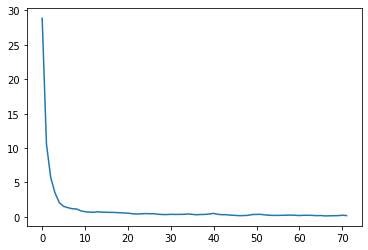

Epoch 1/100
10/10 - 2s - loss: 20.7720 - accuracy: 0.3507 - auc_11: 0.6201 - precision_11: 0.3620 - recall_11: 0.3460 - f1_score: 0.2393 - val_loss: 211.3750 - val_accuracy: 0.4810 - val_auc_11: 0.6756 - val_precision_11: 0.4810 - val_recall_11: 0.4810 - val_f1_score: 0.1299 - 2s/epoch - 204ms/step
Epoch 2/100
10/10 - 0s - loss: 9.6291 - accuracy: 0.4487 - auc_11: 0.7015 - precision_11: 0.4499 - recall_11: 0.4471 - f1_score: 0.2906 - val_loss: 29.9608 - val_accuracy: 0.2595 - val_auc_11: 0.5760 - val_precision_11: 0.2595 - val_recall_11: 0.2595 - val_f1_score: 0.1649 - 169ms/epoch - 17ms/step
Epoch 3/100
10/10 - 0s - loss: 4.6800 - accuracy: 0.4344 - auc_11: 0.7371 - precision_11: 0.4459 - recall_11: 0.4234 - f1_score: 0.3101 - val_loss: 22.5548 - val_accuracy: 0.4114 - val_auc_11: 0.6528 - val_precision_11: 0.4114 - val_recall_11: 0.4114 - val_f1_score: 0.1798 - 180ms/epoch - 18ms/step
Epoch 4/100
10/10 - 0s - loss: 2.3310 - accuracy: 0.4471 - auc_11: 0.7419 - precision_11: 0.4677 - r

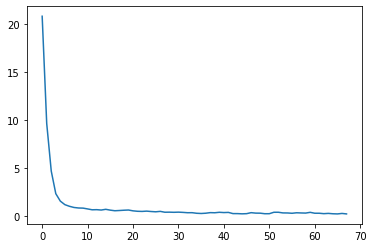

Epoch 1/100
10/10 - 2s - loss: 22.6950 - accuracy: 0.3744 - auc_12: 0.6446 - precision_12: 0.3793 - recall_12: 0.3649 - f1_score: 0.2494 - val_loss: 334.8746 - val_accuracy: 0.2215 - val_auc_12: 0.5134 - val_precision_12: 0.2215 - val_recall_12: 0.2215 - val_f1_score: 0.0725 - 2s/epoch - 161ms/step
Epoch 2/100
10/10 - 0s - loss: 7.5556 - accuracy: 0.4329 - auc_12: 0.6917 - precision_12: 0.4342 - recall_12: 0.4329 - f1_score: 0.2852 - val_loss: 47.5536 - val_accuracy: 0.1013 - val_auc_12: 0.4464 - val_precision_12: 0.1013 - val_recall_12: 0.1013 - val_f1_score: 0.0551 - 169ms/epoch - 17ms/step
Epoch 3/100
10/10 - 0s - loss: 3.6187 - accuracy: 0.4171 - auc_12: 0.7160 - precision_12: 0.4247 - recall_12: 0.4013 - f1_score: 0.2709 - val_loss: 27.3946 - val_accuracy: 0.4367 - val_auc_12: 0.6478 - val_precision_12: 0.4367 - val_recall_12: 0.4367 - val_f1_score: 0.1216 - 181ms/epoch - 18ms/step
Epoch 4/100
10/10 - 0s - loss: 1.9005 - accuracy: 0.4945 - auc_12: 0.7642 - precision_12: 0.5252 - r

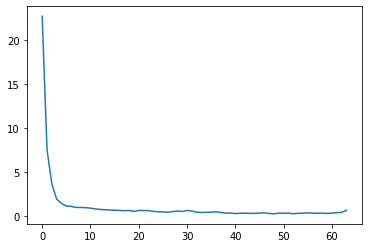

Epoch 1/100
10/10 - 2s - loss: 23.5488 - accuracy: 0.3207 - auc_13: 0.5937 - precision_13: 0.3164 - recall_13: 0.3049 - f1_score: 0.2146 - val_loss: 96.8410 - val_accuracy: 0.5633 - val_auc_13: 0.7271 - val_precision_13: 0.5633 - val_recall_13: 0.5633 - val_f1_score: 0.1744 - 2s/epoch - 161ms/step
Epoch 2/100
10/10 - 0s - loss: 6.7715 - accuracy: 0.4344 - auc_13: 0.6967 - precision_13: 0.4348 - recall_13: 0.4265 - f1_score: 0.3176 - val_loss: 32.5643 - val_accuracy: 0.5633 - val_auc_13: 0.7271 - val_precision_13: 0.5633 - val_recall_13: 0.5633 - val_f1_score: 0.1441 - 170ms/epoch - 17ms/step
Epoch 3/100
10/10 - 0s - loss: 3.4603 - accuracy: 0.4250 - auc_13: 0.7253 - precision_13: 0.4414 - recall_13: 0.4044 - f1_score: 0.3277 - val_loss: 17.9258 - val_accuracy: 0.5696 - val_auc_13: 0.7303 - val_precision_13: 0.5696 - val_recall_13: 0.5696 - val_f1_score: 0.1755 - 170ms/epoch - 17ms/step
Epoch 4/100
10/10 - 0s - loss: 1.9456 - accuracy: 0.4676 - auc_13: 0.7591 - precision_13: 0.5117 - re

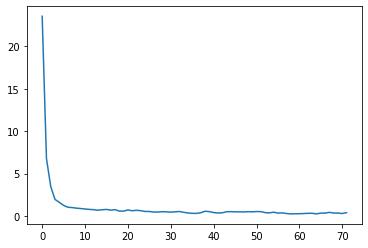

Epoch 1/100
10/10 - 2s - loss: 28.5854 - accuracy: 0.3712 - auc_14: 0.6288 - precision_14: 0.3818 - recall_14: 0.3649 - f1_score: 0.2381 - val_loss: 272.9764 - val_accuracy: 0.2025 - val_auc_14: 0.5016 - val_precision_14: 0.2025 - val_recall_14: 0.2025 - val_f1_score: 0.0674 - 2s/epoch - 162ms/step
Epoch 2/100
10/10 - 0s - loss: 11.4622 - accuracy: 0.3791 - auc_14: 0.6515 - precision_14: 0.3834 - recall_14: 0.3791 - f1_score: 0.2684 - val_loss: 98.2418 - val_accuracy: 0.5316 - val_auc_14: 0.7073 - val_precision_14: 0.5316 - val_recall_14: 0.5316 - val_f1_score: 0.1388 - 167ms/epoch - 17ms/step
Epoch 3/100
10/10 - 0s - loss: 4.6007 - accuracy: 0.4708 - auc_14: 0.7306 - precision_14: 0.4822 - recall_14: 0.4708 - f1_score: 0.3191 - val_loss: 50.0750 - val_accuracy: 0.2025 - val_auc_14: 0.5016 - val_precision_14: 0.2025 - val_recall_14: 0.2025 - val_f1_score: 0.0674 - 169ms/epoch - 17ms/step
Epoch 4/100
10/10 - 0s - loss: 2.4692 - accuracy: 0.4834 - auc_14: 0.7567 - precision_14: 0.4939 - 

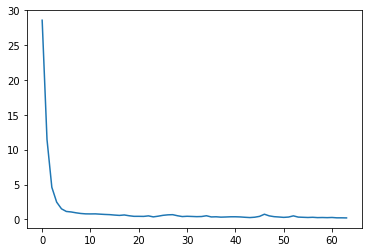

In [23]:
body_rcnn_model_path = Path(os.path.abspath('')).parent / 'models' / 'saved' / 'body_rcnn.h5'
val_accuracy = 0.0

for train_index, val_index in kf.split(full_body_X):
    X_train, X_val = full_body_X[train_index], full_body_X[val_index]
    y_train, y_val = full_body_y[train_index], full_body_y[val_index]
    body_rcnn = build_RCNN(body_features, n_length, body_outputs)
    history = train(body_rcnn, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        body_rcnn.save(body_rcnn_model_path)

In [24]:
body_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
body_rcnn_train_results

{'Accuracy': 0.9067760586738587,
 'ROC/AUC': 0.9848008394241333,
 'Precision': 0.9134167075157166,
 'Recall': 0.8985581994056702,
 'F1-score': 0.8640071153640747}

In [25]:
body_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
body_rcnn_val_results

{'Accuracy': 0.47278878688812254,
 'ROC/AUC': 0.718096387386322,
 'Precision': 0.48057926893234254,
 'Recall': 0.4677493810653687,
 'F1-score': 0.26292245388031005}

### 1.2 Face modality (Action units)

#### About the data

In [6]:
face_X_train, face_X_test, face_y_train, face_y_test, face_feature_names, c = load_dataset('processed', 'AUs')
face_X = face_X_train.copy()
y = face_y_train.copy()

print(face_X_train.shape, face_y_train.shape)
print(face_X_test.shape, face_y_test.shape)

n_length, face_features, face_outputs = face_X_train.shape[2], face_X_train.shape[-1], face_y_train.shape[1]

(756, 1, 350, 10) (756, 5)
(263, 1, 350, 10) (263, 5)


In [7]:
tmp = pd.DataFrame(c)
classes = tmp.value_counts()
classes

No Pain               385
LowerBody Mild        136
LowerBody Moderate     96
UpperBody Mild         72
UpperBody Moderate     67
dtype: int64

In [8]:
lmild, lmoderate, nopain, umild, umoderate = np.sum(y, axis=0)
total = nopain + umild + lmoderate + lmild + umoderate

weight_for_lmild = (1 / lmild) * (total / 2.0)
weight_for_lmoderate = (1 / lmoderate) * (total / 2.0)
weight_for_nopain = (1 / nopain) * (total / 2.0)
weight_for_umild = (1 / umild) * (total / 2.0)
weight_for_umoderate = (1 / umoderate) * (total / 2.0)

class_weight = {0: weight_for_lmild, 1: weight_for_lmoderate, 2: weight_for_nopain, 3: weight_for_umild, 4: weight_for_umoderate}

print('Weight for class "Lower Body Mild Pain": {:.2f}'.format(weight_for_lmild))
print('Weight for class "Lower Body Moderate Pain": {:.2f}'.format(weight_for_lmoderate))
print('Weight for class "No Pain": {:.2f}'.format(weight_for_nopain))
print('Weight for class "Upper Body Mild Pain": {:.2f}'.format(weight_for_umild))
print('Weight for class "Upper Body Moderate Pain": {:.2f}'.format(weight_for_umoderate))

Weight for class "Lower Body Mild Pain": 2.78
Weight for class "Lower Body Moderate Pain": 3.94
Weight for class "No Pain": 0.98
Weight for class "Upper Body Mild Pain": 5.25
Weight for class "Upper Body Moderate Pain": 5.64


#### Train CNN+LSTM

In [50]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []

Epoch 1/100
10/10 - 6s - loss: 1.4902 - accuracy: 0.4487 - auc_15: 0.6976 - precision_15: 0.4965 - recall_15: 0.2334 - f1_score: 0.2169 - val_loss: 1.5554 - val_accuracy: 0.4671 - val_auc_15: 0.6859 - val_precision_15: 0.4671 - val_recall_15: 0.4671 - val_f1_score: 0.1274 - 6s/epoch - 616ms/step
Epoch 2/100
10/10 - 0s - loss: 1.3776 - accuracy: 0.5199 - auc_15: 0.7304 - precision_15: 0.5201 - recall_15: 0.2997 - f1_score: 0.1368 - val_loss: 1.4680 - val_accuracy: 0.4671 - val_auc_15: 0.6497 - val_precision_15: 0.4671 - val_recall_15: 0.4671 - val_f1_score: 0.1274 - 333ms/epoch - 33ms/step
Epoch 3/100
10/10 - 0s - loss: 1.3436 - accuracy: 0.5199 - auc_15: 0.7375 - precision_15: 0.5294 - recall_15: 0.4172 - f1_score: 0.1368 - val_loss: 1.4924 - val_accuracy: 0.4671 - val_auc_15: 0.6678 - val_precision_15: 0.4671 - val_recall_15: 0.4671 - val_f1_score: 0.1274 - 287ms/epoch - 29ms/step
Epoch 4/100
10/10 - 0s - loss: 1.3568 - accuracy: 0.5199 - auc_15: 0.7310 - precision_15: 0.5188 - recall

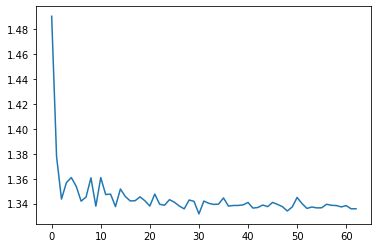

Epoch 1/100
10/10 - 6s - loss: 1.5072 - accuracy: 0.4496 - auc_16: 0.6662 - precision_16: 0.5286 - recall_16: 0.2595 - f1_score: 0.2172 - val_loss: 1.5056 - val_accuracy: 0.4636 - val_auc_16: 0.6540 - val_precision_16: 0.0000e+00 - val_recall_16: 0.0000e+00 - val_f1_score: 0.1267 - 6s/epoch - 621ms/step
Epoch 2/100
10/10 - 0s - loss: 1.3612 - accuracy: 0.5207 - auc_16: 0.7306 - precision_16: 0.5094 - recall_16: 0.2694 - f1_score: 0.1370 - val_loss: 1.5864 - val_accuracy: 0.4636 - val_auc_16: 0.6871 - val_precision_16: 0.4636 - val_recall_16: 0.4636 - val_f1_score: 0.1267 - 297ms/epoch - 30ms/step
Epoch 3/100
10/10 - 0s - loss: 1.3704 - accuracy: 0.5207 - auc_16: 0.7249 - precision_16: 0.5365 - recall_16: 0.3405 - f1_score: 0.1370 - val_loss: 1.4393 - val_accuracy: 0.4636 - val_auc_16: 0.7053 - val_precision_16: 0.0000e+00 - val_recall_16: 0.0000e+00 - val_f1_score: 0.1267 - 337ms/epoch - 34ms/step
Epoch 4/100
10/10 - 0s - loss: 1.3653 - accuracy: 0.5207 - auc_16: 0.7219 - precision_16:

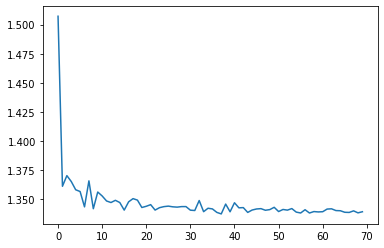

Epoch 1/100
10/10 - 6s - loss: 1.5142 - accuracy: 0.4182 - auc_17: 0.6928 - precision_17: 0.5071 - recall_17: 0.2347 - f1_score: 0.1822 - val_loss: 1.2870 - val_accuracy: 0.5828 - val_auc_17: 0.7699 - val_precision_17: 0.5828 - val_recall_17: 0.5828 - val_f1_score: 0.1473 - 6s/epoch - 637ms/step
Epoch 2/100
10/10 - 0s - loss: 1.4237 - accuracy: 0.4909 - auc_17: 0.7067 - precision_17: 0.4706 - recall_17: 0.1719 - f1_score: 0.1317 - val_loss: 1.4160 - val_accuracy: 0.5828 - val_auc_17: 0.7343 - val_precision_17: 0.0000e+00 - val_recall_17: 0.0000e+00 - val_f1_score: 0.1473 - 287ms/epoch - 29ms/step
Epoch 3/100
10/10 - 0s - loss: 1.4071 - accuracy: 0.4909 - auc_17: 0.7053 - precision_17: 0.4887 - recall_17: 0.1785 - f1_score: 0.1317 - val_loss: 1.3446 - val_accuracy: 0.5828 - val_auc_17: 0.7343 - val_precision_17: 0.0000e+00 - val_recall_17: 0.0000e+00 - val_f1_score: 0.1473 - 284ms/epoch - 28ms/step
Epoch 4/100
10/10 - 0s - loss: 1.4020 - accuracy: 0.4909 - auc_17: 0.7019 - precision_17:

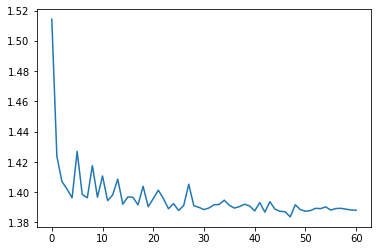

Epoch 1/100
10/10 - 6s - loss: 1.5521 - accuracy: 0.3868 - auc_18: 0.6709 - precision_18: 0.4847 - recall_18: 0.1306 - f1_score: 0.2142 - val_loss: 1.3374 - val_accuracy: 0.5364 - val_auc_18: 0.7351 - val_precision_18: 0.5364 - val_recall_18: 0.5364 - val_f1_score: 0.1397 - 6s/epoch - 641ms/step
Epoch 2/100
10/10 - 0s - loss: 1.3821 - accuracy: 0.5025 - auc_18: 0.7259 - precision_18: 0.5063 - recall_18: 0.2678 - f1_score: 0.1338 - val_loss: 1.4238 - val_accuracy: 0.5364 - val_auc_18: 0.7086 - val_precision_18: 0.0000e+00 - val_recall_18: 0.0000e+00 - val_f1_score: 0.1397 - 286ms/epoch - 29ms/step
Epoch 3/100
10/10 - 0s - loss: 1.3952 - accuracy: 0.5025 - auc_18: 0.7162 - precision_18: 0.4459 - recall_18: 0.1157 - f1_score: 0.1338 - val_loss: 1.3614 - val_accuracy: 0.5364 - val_auc_18: 0.7119 - val_precision_18: 0.0000e+00 - val_recall_18: 0.0000e+00 - val_f1_score: 0.1397 - 288ms/epoch - 29ms/step
Epoch 4/100
10/10 - 0s - loss: 1.3809 - accuracy: 0.5025 - auc_18: 0.7174 - precision_18:

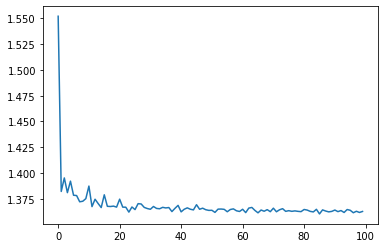

Epoch 1/100
10/10 - 6s - loss: 1.5267 - accuracy: 0.3669 - auc_19: 0.6493 - precision_19: 0.5123 - recall_19: 0.2413 - f1_score: 0.2092 - val_loss: 1.3891 - val_accuracy: 0.4967 - val_auc_19: 0.6921 - val_precision_19: 0.4967 - val_recall_19: 0.4967 - val_f1_score: 0.1327 - 6s/epoch - 642ms/step
Epoch 2/100
10/10 - 0s - loss: 1.4026 - accuracy: 0.5124 - auc_19: 0.7118 - precision_19: 0.5018 - recall_19: 0.2364 - f1_score: 0.1355 - val_loss: 1.4543 - val_accuracy: 0.4967 - val_auc_19: 0.7219 - val_precision_19: 0.4967 - val_recall_19: 0.4967 - val_f1_score: 0.1327 - 292ms/epoch - 29ms/step
Epoch 3/100
10/10 - 0s - loss: 1.3837 - accuracy: 0.5124 - auc_19: 0.7181 - precision_19: 0.5156 - recall_19: 0.2727 - f1_score: 0.1355 - val_loss: 1.3799 - val_accuracy: 0.4967 - val_auc_19: 0.7301 - val_precision_19: 0.0000e+00 - val_recall_19: 0.0000e+00 - val_f1_score: 0.1327 - 329ms/epoch - 33ms/step
Epoch 4/100
10/10 - 0s - loss: 1.3607 - accuracy: 0.5124 - auc_19: 0.7268 - precision_19: 0.5234 

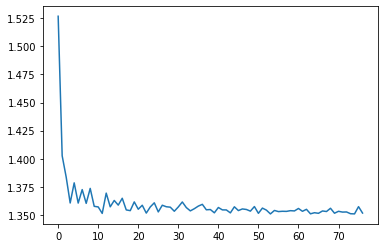

In [51]:
face_cnnlstm_model_path = Path(os.path.abspath('')).parent / 'models' / 'saved' / 'face_cnnlstm.h5'
val_accuracy = 0.0

for train_index, val_index in kf.split(face_X):
    X_train, X_val = face_X[train_index], face_X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    face_cnnlstm = build_CNNLSTM(face_features, n_length, face_outputs)
    history = train(face_cnnlstm, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        face_cnnlstm.save(face_cnnlstm_model_path)

In [52]:
face_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
face_cnnlstm_train_results

{'Accuracy': 0.509262764453888,
 'ROC/AUC': 0.7281912207603455,
 'Precision': 0.5149618446826935,
 'Recall': 0.23281320184469223,
 'F1-score': 0.13495510220527648}

In [53]:
face_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
face_cnnlstm_val_results

{'Accuracy': 0.5093150973320008,
 'ROC/AUC': 0.725250518321991,
 'Precision': 0.39275881052017214,
 'Recall': 0.39275881052017214,
 'F1-score': 0.13474599719047547}

#### Train ConvLSTM

In [54]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []

In [56]:
face_convlstm_model_path = Path(os.path.abspath('')).parent / 'models' / 'saved' / 'face_convlstm.h5'
val_accuracy = 0.0

for train_index, val_index in kf.split(face_X):
    X_train, X_val = face_X[train_index], face_X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    face_convLSTM = build_convLSTM(face_features, n_length, face_outputs)
    history = train(face_convLSTM, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        face_convLSTM.save(face_convlstm_model_path)

Epoch 1/100


InvalidArgumentError: Graph execution error:

Detected at node 'assert_greater_equal/Assert/AssertGuard/Assert' defined at (most recent call last):
    File "c:\python39\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\python39\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\python39\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "c:\python39\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "c:\python39\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\IPython\core\interactiveshell.py", line 2768, in run_cell
      result = self._run_cell(
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\IPython\core\interactiveshell.py", line 2814, in _run_cell
      return runner(coro)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\IPython\core\interactiveshell.py", line 3012, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\IPython\core\interactiveshell.py", line 3191, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\IPython\core\interactiveshell.py", line 3251, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\angel\AppData\Local\Temp\ipykernel_17916\1987766981.py", line 8, in <module>
      history = train(face_convLSTM, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    File "C:\Users\angel\AppData\Local\Temp\ipykernel_17916\3848018386.py", line 8, in train
      history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\training.py", line 864, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\training.py", line 957, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\compile_utils.py", line 459, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\utils\metrics_utils.py", line 70, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\metrics.py", line 178, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\metrics.py", line 2347, in update_state
      return metrics_utils.update_confusion_matrix_variables(
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\utils\metrics_utils.py", line 602, in update_confusion_matrix_variables
      tf.compat.v1.assert_greater_equal(
Node: 'assert_greater_equal/Assert/AssertGuard/Assert'
Detected at node 'assert_greater_equal/Assert/AssertGuard/Assert' defined at (most recent call last):
    File "c:\python39\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\python39\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\python39\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "c:\python39\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "c:\python39\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\IPython\core\interactiveshell.py", line 2768, in run_cell
      result = self._run_cell(
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\IPython\core\interactiveshell.py", line 2814, in _run_cell
      return runner(coro)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\IPython\core\interactiveshell.py", line 3012, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\IPython\core\interactiveshell.py", line 3191, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\IPython\core\interactiveshell.py", line 3251, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\angel\AppData\Local\Temp\ipykernel_17916\1987766981.py", line 8, in <module>
      history = train(face_convLSTM, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    File "C:\Users\angel\AppData\Local\Temp\ipykernel_17916\3848018386.py", line 8, in train
      history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\training.py", line 864, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\training.py", line 957, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\compile_utils.py", line 459, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\utils\metrics_utils.py", line 70, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\metrics.py", line 178, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\metrics.py", line 2347, in update_state
      return metrics_utils.update_confusion_matrix_variables(
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\utils\metrics_utils.py", line 602, in update_confusion_matrix_variables
      tf.compat.v1.assert_greater_equal(
Node: 'assert_greater_equal/Assert/AssertGuard/Assert'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (model_21/dense_65/Softmax:0) = ] [[0.126779154 0.0784052 0.601056933...]...] [y (Cast_6/x:0) = ] [0]
	 [[{{node assert_greater_equal/Assert/AssertGuard/Assert}}]]
	 [[assert_less_equal_2/Assert/AssertGuard/pivot_f/_3735/_779]]
  (1) INVALID_ARGUMENT:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (model_21/dense_65/Softmax:0) = ] [[0.126779154 0.0784052 0.601056933...]...] [y (Cast_6/x:0) = ] [0]
	 [[{{node assert_greater_equal/Assert/AssertGuard/Assert}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_548999]

In [ ]:
face_convlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
face_convlstm_train_results

{'Accuracy': 0.6638770461082458,
 'ROC/AUC': 0.9122679352760314,
 'Precision': 0.8814139366149902,
 'Recall': 0.543752384185791,
 'F1-score': 0.6547083377838134}

In [ ]:
face_convlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
face_convlstm_val_results

{'Accuracy': 0.3668051242828369,
 'ROC/AUC': 0.6265398144721985,
 'Precision': 0.4201259255409241,
 'Recall': 0.24778469800949096,
 'F1-score': 0.2831133186817169}

#### Train RCNN

In [19]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []

In [20]:
face_rcnn_model_path = Path(os.path.abspath('')).parent / 'models' / 'saved' / 'face_rcnn.h5'
val_accuracy = 0.0

for train_index, val_index in kf.split(face_X):
    X_train, X_val = face_X[train_index], face_X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    face_rcnn = build_RCNN(face_features, n_length, face_outputs)
    history = train(face_rcnn, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        face_rcnn.save(face_rcnn_model_path)

Epoch 1/100


InvalidArgumentError: Graph execution error:

Detected at node 'assert_greater_equal/Assert/AssertGuard/Assert' defined at (most recent call last):
    File "c:\python39\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\python39\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\python39\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "c:\python39\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "c:\python39\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\IPython\core\interactiveshell.py", line 2768, in run_cell
      result = self._run_cell(
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\IPython\core\interactiveshell.py", line 2814, in _run_cell
      return runner(coro)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\IPython\core\interactiveshell.py", line 3012, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\IPython\core\interactiveshell.py", line 3191, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\IPython\core\interactiveshell.py", line 3251, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\angel\AppData\Local\Temp\ipykernel_36508\2327943240.py", line 8, in <module>
      history = train(face_rcnn, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    File "C:\Users\angel\AppData\Local\Temp\ipykernel_36508\3848018386.py", line 8, in train
      history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\training.py", line 864, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\training.py", line 957, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\compile_utils.py", line 459, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\utils\metrics_utils.py", line 70, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\metrics.py", line 178, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\metrics.py", line 2347, in update_state
      return metrics_utils.update_confusion_matrix_variables(
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\utils\metrics_utils.py", line 602, in update_confusion_matrix_variables
      tf.compat.v1.assert_greater_equal(
Node: 'assert_greater_equal/Assert/AssertGuard/Assert'
Detected at node 'assert_greater_equal/Assert/AssertGuard/Assert' defined at (most recent call last):
    File "c:\python39\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\python39\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\python39\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "c:\python39\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "c:\python39\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\IPython\core\interactiveshell.py", line 2768, in run_cell
      result = self._run_cell(
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\IPython\core\interactiveshell.py", line 2814, in _run_cell
      return runner(coro)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\IPython\core\interactiveshell.py", line 3012, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\IPython\core\interactiveshell.py", line 3191, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\IPython\core\interactiveshell.py", line 3251, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\angel\AppData\Local\Temp\ipykernel_36508\2327943240.py", line 8, in <module>
      history = train(face_rcnn, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    File "C:\Users\angel\AppData\Local\Temp\ipykernel_36508\3848018386.py", line 8, in train
      history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\training.py", line 864, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\training.py", line 957, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\compile_utils.py", line 459, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\utils\metrics_utils.py", line 70, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\metrics.py", line 178, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\metrics.py", line 2347, in update_state
      return metrics_utils.update_confusion_matrix_variables(
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\utils\metrics_utils.py", line 602, in update_confusion_matrix_variables
      tf.compat.v1.assert_greater_equal(
Node: 'assert_greater_equal/Assert/AssertGuard/Assert'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (model_2/dense_8/Softmax:0) = ] [[nan nan nan...]...] [y (Cast_6/x:0) = ] [0]
	 [[{{node assert_greater_equal/Assert/AssertGuard/Assert}}]]
	 [[assert_greater_equal_1/Assert/AssertGuard/pivot_f/_23/_67]]
  (1) INVALID_ARGUMENT:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (model_2/dense_8/Softmax:0) = ] [[nan nan nan...]...] [y (Cast_6/x:0) = ] [0]
	 [[{{node assert_greater_equal/Assert/AssertGuard/Assert}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_8285]

In [ ]:
face_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
face_rcnn_train_results

{'Accuracy': 0.6429121255874634,
 'ROC/AUC': 0.8842045187950134,
 'Precision': 0.8476066708564758,
 'Recall': 0.5395500540733338,
 'F1-score': 0.6350567698478699}

In [ ]:
face_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
face_rcnn_val_results

{'Accuracy': 0.3761509120464325,
 'ROC/AUC': 0.6239370703697205,
 'Precision': 0.43058923482894895,
 'Recall': 0.22921425998210906,
 'F1-score': 0.30809721946716306}

### 1.3 Head modality (pose)

#### About the data

In [21]:
head_X_train, head_X_test, head_y_train, head_y_test, head_feature_names, c = load_dataset('processed', 'pose')
head_X = head_X_train.copy()
head_y = head_y_train.copy()

print(head_X_train.shape, head_y_train.shape)
print(head_X_test.shape, head_y_test.shape)

n_length, head_features, head_outputs = head_X_train.shape[2], head_X_train.shape[-1], head_y_train.shape[1]

(756, 1, 350, 6) (756, 5)
(263, 1, 350, 6) (263, 5)


#### Train CNN+LSTM

In [ ]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []

Epoch 1/100
7/7 - 6s - loss: 1.4567 - accuracy: 0.3357 - auc_30: 0.5726 - precision_30: 0.3438 - recall_30: 0.0513 - f1_score: 0.2130 - val_loss: 1.3896 - val_accuracy: 0.3796 - val_auc_30: 0.6358 - val_precision_30: 0.0000e+00 - val_recall_30: 0.0000e+00 - val_f1_score: 0.1376 - 6s/epoch - 850ms/step
Epoch 2/100
7/7 - 0s - loss: 1.3491 - accuracy: 0.4009 - auc_30: 0.6101 - precision_30: 0.0000e+00 - recall_30: 0.0000e+00 - f1_score: 0.1431 - val_loss: 1.3438 - val_accuracy: 0.3796 - val_auc_30: 0.6323 - val_precision_30: 0.0000e+00 - val_recall_30: 0.0000e+00 - val_f1_score: 0.1376 - 259ms/epoch - 37ms/step
Epoch 3/100
7/7 - 0s - loss: 1.3448 - accuracy: 0.4009 - auc_30: 0.6052 - precision_30: 0.0000e+00 - recall_30: 0.0000e+00 - f1_score: 0.1431 - val_loss: 1.3376 - val_accuracy: 0.3796 - val_auc_30: 0.6605 - val_precision_30: 0.0000e+00 - val_recall_30: 0.0000e+00 - val_f1_score: 0.1376 - 254ms/epoch - 36ms/step
Epoch 4/100
7/7 - 0s - loss: 1.3439 - accuracy: 0.4009 - auc_30: 0.6098

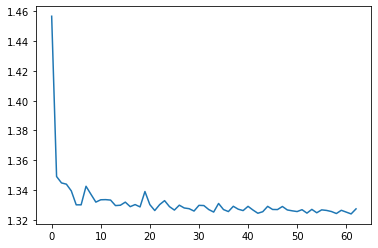

Epoch 1/100
7/7 - 6s - loss: 1.4621 - accuracy: 0.3800 - auc_31: 0.5866 - precision_31: 0.3770 - recall_31: 0.1072 - f1_score: 0.1913 - val_loss: 1.3449 - val_accuracy: 0.3796 - val_auc_31: 0.5941 - val_precision_31: 0.0000e+00 - val_recall_31: 0.0000e+00 - val_f1_score: 0.1376 - 6s/epoch - 897ms/step
Epoch 2/100
7/7 - 0s - loss: 1.3377 - accuracy: 0.4009 - auc_31: 0.6211 - precision_31: 0.0000e+00 - recall_31: 0.0000e+00 - f1_score: 0.1431 - val_loss: 1.3954 - val_accuracy: 0.3796 - val_auc_31: 0.5833 - val_precision_31: 0.0000e+00 - val_recall_31: 0.0000e+00 - val_f1_score: 0.1376 - 214ms/epoch - 31ms/step
Epoch 3/100
7/7 - 0s - loss: 1.3285 - accuracy: 0.4009 - auc_31: 0.6335 - precision_31: 0.0000e+00 - recall_31: 0.0000e+00 - f1_score: 0.1431 - val_loss: 1.3557 - val_accuracy: 0.3796 - val_auc_31: 0.5926 - val_precision_31: 0.0000e+00 - val_recall_31: 0.0000e+00 - val_f1_score: 0.1376 - 209ms/epoch - 30ms/step
Epoch 4/100
7/7 - 0s - loss: 1.3251 - accuracy: 0.4009 - auc_31: 0.6323

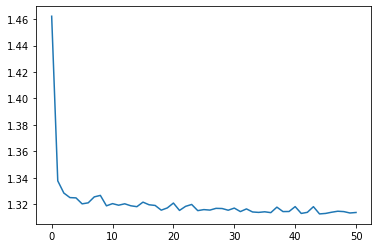

Epoch 1/100
7/7 - 6s - loss: 1.4698 - accuracy: 0.3116 - auc_32: 0.5561 - precision_32: 0.4062 - recall_32: 0.0605 - f1_score: 0.2219 - val_loss: 1.3936 - val_accuracy: 0.1869 - val_auc_32: 0.5234 - val_precision_32: 0.0000e+00 - val_recall_32: 0.0000e+00 - val_f1_score: 0.0787 - 6s/epoch - 855ms/step
Epoch 2/100
7/7 - 0s - loss: 1.3376 - accuracy: 0.3349 - auc_32: 0.6201 - precision_32: 0.0000e+00 - recall_32: 0.0000e+00 - f1_score: 0.2059 - val_loss: 1.3705 - val_accuracy: 0.3832 - val_auc_32: 0.5888 - val_precision_32: 0.0000e+00 - val_recall_32: 0.0000e+00 - val_f1_score: 0.1385 - 278ms/epoch - 40ms/step
Epoch 3/100
7/7 - 0s - loss: 1.3281 - accuracy: 0.4000 - auc_32: 0.6252 - precision_32: 0.0000e+00 - recall_32: 0.0000e+00 - f1_score: 0.1429 - val_loss: 1.3554 - val_accuracy: 0.3832 - val_auc_32: 0.5888 - val_precision_32: 0.0000e+00 - val_recall_32: 0.0000e+00 - val_f1_score: 0.1385 - 251ms/epoch - 36ms/step
Epoch 4/100
7/7 - 0s - loss: 1.3350 - accuracy: 0.4000 - auc_32: 0.6194

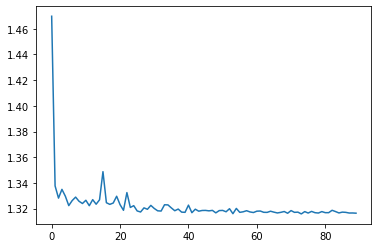

Epoch 1/100
7/7 - 6s - loss: 1.4406 - accuracy: 0.3395 - auc_33: 0.5831 - precision_33: 0.4182 - recall_33: 0.1070 - f1_score: 0.2468 - val_loss: 1.3374 - val_accuracy: 0.2710 - val_auc_33: 0.5981 - val_precision_33: 0.0000e+00 - val_recall_33: 0.0000e+00 - val_f1_score: 0.1066 - 6s/epoch - 865ms/step
Epoch 2/100
7/7 - 0s - loss: 1.3458 - accuracy: 0.3674 - auc_33: 0.6113 - precision_33: 0.0000e+00 - recall_33: 0.0000e+00 - f1_score: 0.1725 - val_loss: 1.3196 - val_accuracy: 0.3925 - val_auc_33: 0.6386 - val_precision_33: 0.0000e+00 - val_recall_33: 0.0000e+00 - val_f1_score: 0.1409 - 272ms/epoch - 39ms/step
Epoch 3/100
7/7 - 0s - loss: 1.3282 - accuracy: 0.3977 - auc_33: 0.6266 - precision_33: 0.0000e+00 - recall_33: 0.0000e+00 - f1_score: 0.1423 - val_loss: 1.3481 - val_accuracy: 0.3925 - val_auc_33: 0.6137 - val_precision_33: 0.0000e+00 - val_recall_33: 0.0000e+00 - val_f1_score: 0.1409 - 210ms/epoch - 30ms/step
Epoch 4/100
7/7 - 0s - loss: 1.3464 - accuracy: 0.3674 - auc_33: 0.6102

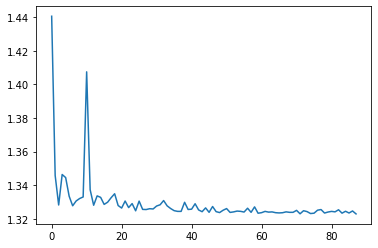

Epoch 1/100
7/7 - 6s - loss: 1.4863 - accuracy: 0.3395 - auc_34: 0.5540 - precision_34: 0.3906 - recall_34: 0.0581 - f1_score: 0.2524 - val_loss: 1.2860 - val_accuracy: 0.4486 - val_auc_34: 0.6575 - val_precision_34: 0.0000e+00 - val_recall_34: 0.0000e+00 - val_f1_score: 0.1548 - 6s/epoch - 849ms/step
Epoch 2/100
7/7 - 0s - loss: 1.3682 - accuracy: 0.3837 - auc_34: 0.5965 - precision_34: 0.0000e+00 - recall_34: 0.0000e+00 - f1_score: 0.1387 - val_loss: 1.3114 - val_accuracy: 0.4486 - val_auc_34: 0.6822 - val_precision_34: 0.0000e+00 - val_recall_34: 0.0000e+00 - val_f1_score: 0.1548 - 213ms/epoch - 30ms/step
Epoch 3/100
7/7 - 0s - loss: 1.3563 - accuracy: 0.3837 - auc_34: 0.5973 - precision_34: 0.0000e+00 - recall_34: 0.0000e+00 - f1_score: 0.1387 - val_loss: 1.3094 - val_accuracy: 0.4486 - val_auc_34: 0.6542 - val_precision_34: 0.0000e+00 - val_recall_34: 0.0000e+00 - val_f1_score: 0.1548 - 210ms/epoch - 30ms/step
Epoch 4/100
7/7 - 0s - loss: 1.3386 - accuracy: 0.3837 - auc_34: 0.6130

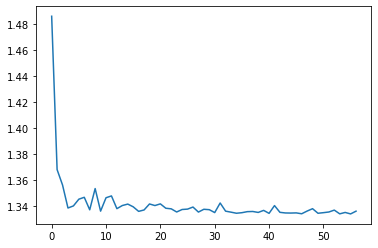

In [ ]:
head_cnnlstm_model_path = Path(os.path.abspath('')).parent / 'models' / 'saved' / 'head_cnnlstm.h5'
val_accuracy = 0.0

for train_index, val_index in kf.split(head_X):
    X_train, X_val = head_X[train_index], head_X[val_index]
    y_train, y_val = head_y[train_index], head_y[val_index]
    head_cnnlstm = build_CNNLSTM(head_features, n_length, head_outputs)
    history = train(head_cnnlstm, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        head_cnnlstm.save(head_cnnlstm_model_path)

In [ ]:
head_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
head_cnnlstm_train_results

{'Accuracy': 0.3966520309448242,
 'ROC/AUC': 0.6215947985649108,
 'Precision': 0.0,
 'Recall': 0.0,
 'F1-score': 0.14199303686618805}

In [ ]:
head_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
head_cnnlstm_val_results

{'Accuracy': 0.3967116713523865,
 'ROC/AUC': 0.629496955871582,
 'Precision': 0.0,
 'Recall': 0.0,
 'F1-score': 0.14189192056655883}

#### Train ConvLSTM

In [ ]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []

Epoch 1/100
7/7 - 10s - loss: 2.7306 - accuracy: 0.3240 - auc_35: 0.5877 - precision_35: 0.3423 - recall_35: 0.2378 - f1_score: 0.2339 - val_loss: 1.8405 - val_accuracy: 0.2315 - val_auc_35: 0.5881 - val_precision_35: 0.2315 - val_recall_35: 0.2315 - val_f1_score: 0.0940 - 10s/epoch - 1s/step
Epoch 2/100
7/7 - 1s - loss: 1.5714 - accuracy: 0.2331 - auc_35: 0.5465 - precision_35: 0.2870 - recall_35: 0.1538 - f1_score: 0.1930 - val_loss: 1.5009 - val_accuracy: 0.3796 - val_auc_35: 0.6077 - val_precision_35: 0.3796 - val_recall_35: 0.3796 - val_f1_score: 0.1376 - 760ms/epoch - 109ms/step
Epoch 3/100
7/7 - 1s - loss: 1.4513 - accuracy: 0.4009 - auc_35: 0.6057 - precision_35: 0.4010 - recall_35: 0.1795 - f1_score: 0.1431 - val_loss: 1.3619 - val_accuracy: 0.2315 - val_auc_35: 0.5944 - val_precision_35: 0.0000e+00 - val_recall_35: 0.0000e+00 - val_f1_score: 0.0940 - 818ms/epoch - 117ms/step
Epoch 4/100
7/7 - 1s - loss: 1.3818 - accuracy: 0.3566 - auc_35: 0.6060 - precision_35: 0.0000e+00 - r

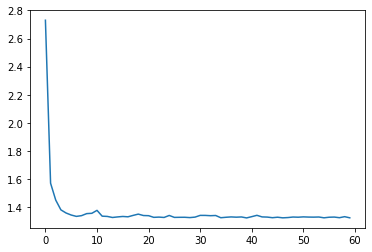

Epoch 1/100
7/7 - 9s - loss: 2.6130 - accuracy: 0.2984 - auc_36: 0.6008 - precision_36: 0.3256 - recall_36: 0.2284 - f1_score: 0.2147 - val_loss: 1.9833 - val_accuracy: 0.2222 - val_auc_36: 0.5401 - val_precision_36: 0.2222 - val_recall_36: 0.2222 - val_f1_score: 0.0909 - 9s/epoch - 1s/step
Epoch 2/100
7/7 - 1s - loss: 1.6731 - accuracy: 0.2937 - auc_36: 0.5442 - precision_36: 0.3438 - recall_36: 0.2051 - f1_score: 0.2050 - val_loss: 1.4593 - val_accuracy: 0.1944 - val_auc_36: 0.5154 - val_precision_36: 0.0000e+00 - val_recall_36: 0.0000e+00 - val_f1_score: 0.0814 - 737ms/epoch - 105ms/step
Epoch 3/100
7/7 - 1s - loss: 1.4057 - accuracy: 0.2914 - auc_36: 0.5959 - precision_36: 0.0000e+00 - recall_36: 0.0000e+00 - f1_score: 0.1748 - val_loss: 1.5449 - val_accuracy: 0.3796 - val_auc_36: 0.5926 - val_precision_36: 0.0000e+00 - val_recall_36: 0.0000e+00 - val_f1_score: 0.1376 - 678ms/epoch - 97ms/step
Epoch 4/100
7/7 - 1s - loss: 1.3925 - accuracy: 0.4009 - auc_36: 0.6293 - precision_36: 0

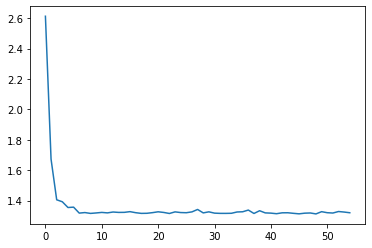

Epoch 1/100
7/7 - 9s - loss: 2.6020 - accuracy: 0.2814 - auc_37: 0.5978 - precision_37: 0.3056 - recall_37: 0.2558 - f1_score: 0.2050 - val_loss: 2.2266 - val_accuracy: 0.1869 - val_auc_37: 0.5173 - val_precision_37: 0.1869 - val_recall_37: 0.1869 - val_f1_score: 0.0787 - 9s/epoch - 1s/step
Epoch 2/100
7/7 - 1s - loss: 1.6355 - accuracy: 0.3000 - auc_37: 0.5511 - precision_37: 0.2248 - recall_37: 0.0674 - f1_score: 0.2152 - val_loss: 1.4788 - val_accuracy: 0.2430 - val_auc_37: 0.5639 - val_precision_37: 0.0000e+00 - val_recall_37: 0.0000e+00 - val_f1_score: 0.0977 - 742ms/epoch - 106ms/step
Epoch 3/100
7/7 - 1s - loss: 1.4152 - accuracy: 0.3256 - auc_37: 0.6069 - precision_37: 0.2273 - recall_37: 0.0233 - f1_score: 0.1918 - val_loss: 1.4949 - val_accuracy: 0.3832 - val_auc_37: 0.5900 - val_precision_37: 0.0000e+00 - val_recall_37: 0.0000e+00 - val_f1_score: 0.1385 - 679ms/epoch - 97ms/step
Epoch 4/100
7/7 - 1s - loss: 1.3871 - accuracy: 0.3093 - auc_37: 0.5985 - precision_37: 0.0000e+0

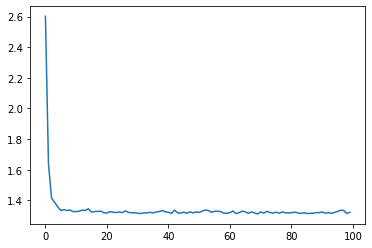

Epoch 1/100
7/7 - 9s - loss: 2.7774 - accuracy: 0.3093 - auc_38: 0.5763 - precision_38: 0.3377 - recall_38: 0.2419 - f1_score: 0.2205 - val_loss: 1.8206 - val_accuracy: 0.1963 - val_auc_38: 0.4249 - val_precision_38: 0.1963 - val_recall_38: 0.1963 - val_f1_score: 0.0820 - 9s/epoch - 1s/step
Epoch 2/100
7/7 - 1s - loss: 1.6287 - accuracy: 0.2791 - auc_38: 0.5089 - precision_38: 0.2701 - recall_38: 0.1093 - f1_score: 0.2100 - val_loss: 1.3837 - val_accuracy: 0.3925 - val_auc_38: 0.6389 - val_precision_38: 0.3925 - val_recall_38: 0.3925 - val_f1_score: 0.1409 - 740ms/epoch - 106ms/step
Epoch 3/100
7/7 - 1s - loss: 1.4396 - accuracy: 0.3465 - auc_38: 0.6198 - precision_38: 0.4141 - recall_38: 0.1233 - f1_score: 0.1893 - val_loss: 1.3713 - val_accuracy: 0.3925 - val_auc_38: 0.6424 - val_precision_38: 0.0000e+00 - val_recall_38: 0.0000e+00 - val_f1_score: 0.1409 - 750ms/epoch - 107ms/step
Epoch 4/100
7/7 - 1s - loss: 1.3605 - accuracy: 0.3977 - auc_38: 0.6081 - precision_38: 0.0000e+00 - rec

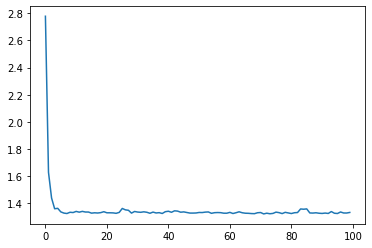

Epoch 1/100
7/7 - 10s - loss: 3.1950 - accuracy: 0.3395 - auc_39: 0.6021 - precision_39: 0.3517 - recall_39: 0.2372 - f1_score: 0.2839 - val_loss: 1.5395 - val_accuracy: 0.1776 - val_auc_39: 0.5599 - val_precision_39: 0.1111 - val_recall_39: 0.0093 - val_f1_score: 0.0754 - 10s/epoch - 1s/step
Epoch 2/100
7/7 - 1s - loss: 1.4938 - accuracy: 0.2860 - auc_39: 0.5528 - precision_39: 0.3750 - recall_39: 0.0070 - f1_score: 0.2124 - val_loss: 1.2846 - val_accuracy: 0.4579 - val_auc_39: 0.6663 - val_precision_39: 0.0000e+00 - val_recall_39: 0.0000e+00 - val_f1_score: 0.1870 - 733ms/epoch - 105ms/step
Epoch 3/100
7/7 - 1s - loss: 1.3670 - accuracy: 0.3419 - auc_39: 0.5998 - precision_39: 0.0000e+00 - recall_39: 0.0000e+00 - f1_score: 0.2138 - val_loss: 1.2875 - val_accuracy: 0.4486 - val_auc_39: 0.6553 - val_precision_39: 0.0000e+00 - val_recall_39: 0.0000e+00 - val_f1_score: 0.1548 - 724ms/epoch - 103ms/step
Epoch 4/100
7/7 - 1s - loss: 1.3441 - accuracy: 0.3837 - auc_39: 0.6211 - precision_39

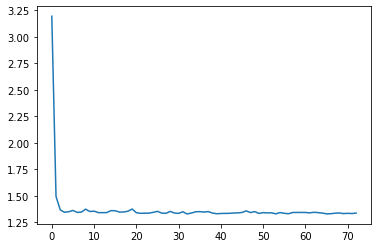

In [ ]:
head_convLSTM_model_path = Path(os.path.abspath('')).parent / 'models' / 'saved' / 'head_convLSTM.h5'
val_accuracy = 0.0

for train_index, val_index in kf.split(head_X):
    X_train, X_val = head_X[train_index], head_X[val_index]
    y_train, y_val = head_y[train_index], head_y[val_index]
    head_convLSTM = build_convLSTM(head_features, n_length, head_outputs)
    history = train(head_convLSTM, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        head_convLSTM.save(head_convLSTM_model_path)

In [ ]:
head_convLSTM_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
head_convLSTM_train_results

{'Accuracy': 0.4022334277629852,
 'ROC/AUC': 0.6222200632095337,
 'Precision': 0.0,
 'Recall': 0.0,
 'F1-score': 0.15946614146232604}

In [ ]:
head_convLSTM_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
head_convLSTM_val_results

{'Accuracy': 0.3985808312892914,
 'ROC/AUC': 0.6186633706092834,
 'Precision': 0.0,
 'Recall': 0.0,
 'F1-score': 0.14831812381744386}

#### Train RCNN

In [22]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []

In [23]:
head_rcnn_model_path = Path(os.path.abspath('')).parent / 'models' / 'saved' / 'head_rcnn.h5'
val_accuracy = 0.0

for train_index, val_index in kf.split(head_X):
    X_train, X_val = head_X[train_index], head_X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    head_rcnn = build_RCNN(head_features, n_length, head_outputs)
    history = train(head_rcnn, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        head_rcnn.save(head_rcnn_model_path)

Epoch 1/100


InvalidArgumentError: Graph execution error:

Detected at node 'assert_greater_equal/Assert/AssertGuard/Assert' defined at (most recent call last):
    File "c:\python39\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\python39\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\python39\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "c:\python39\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "c:\python39\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\IPython\core\interactiveshell.py", line 2768, in run_cell
      result = self._run_cell(
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\IPython\core\interactiveshell.py", line 2814, in _run_cell
      return runner(coro)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\IPython\core\interactiveshell.py", line 3012, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\IPython\core\interactiveshell.py", line 3191, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\IPython\core\interactiveshell.py", line 3251, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\angel\AppData\Local\Temp\ipykernel_36508\3189030537.py", line 8, in <module>
      history = train(head_rcnn, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    File "C:\Users\angel\AppData\Local\Temp\ipykernel_36508\3848018386.py", line 8, in train
      history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\training.py", line 864, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\training.py", line 957, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\compile_utils.py", line 459, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\utils\metrics_utils.py", line 70, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\metrics.py", line 178, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\metrics.py", line 2347, in update_state
      return metrics_utils.update_confusion_matrix_variables(
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\utils\metrics_utils.py", line 602, in update_confusion_matrix_variables
      tf.compat.v1.assert_greater_equal(
Node: 'assert_greater_equal/Assert/AssertGuard/Assert'
Detected at node 'assert_greater_equal/Assert/AssertGuard/Assert' defined at (most recent call last):
    File "c:\python39\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\python39\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\python39\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "c:\python39\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "c:\python39\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\IPython\core\interactiveshell.py", line 2768, in run_cell
      result = self._run_cell(
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\IPython\core\interactiveshell.py", line 2814, in _run_cell
      return runner(coro)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\IPython\core\interactiveshell.py", line 3012, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\IPython\core\interactiveshell.py", line 3191, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\IPython\core\interactiveshell.py", line 3251, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\angel\AppData\Local\Temp\ipykernel_36508\3189030537.py", line 8, in <module>
      history = train(head_rcnn, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    File "C:\Users\angel\AppData\Local\Temp\ipykernel_36508\3848018386.py", line 8, in train
      history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\training.py", line 864, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\training.py", line 957, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\compile_utils.py", line 459, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\utils\metrics_utils.py", line 70, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\metrics.py", line 178, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\metrics.py", line 2347, in update_state
      return metrics_utils.update_confusion_matrix_variables(
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\utils\metrics_utils.py", line 602, in update_confusion_matrix_variables
      tf.compat.v1.assert_greater_equal(
Node: 'assert_greater_equal/Assert/AssertGuard/Assert'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (model_3/dense_11/Softmax:0) = ] [[nan nan nan...]...] [y (Cast_6/x:0) = ] [0]
	 [[{{node assert_greater_equal/Assert/AssertGuard/Assert}}]]
	 [[assert_greater_equal_1/Assert/AssertGuard/pivot_f/_23/_67]]
  (1) INVALID_ARGUMENT:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (model_3/dense_11/Softmax:0) = ] [[nan nan nan...]...] [y (Cast_6/x:0) = ] [0]
	 [[{{node assert_greater_equal/Assert/AssertGuard/Assert}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_11041]

In [ ]:
head_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
head_rcnn_train_results

{'Accuracy': 0.40782999992370605,
 'ROC/AUC': 0.6322595596313476,
 'Precision': 0.38955445885658263,
 'Recall': 0.057278691232204436,
 'F1-score': 0.2288023054599762}

In [ ]:
head_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
head_rcnn_val_results

{'Accuracy': 0.38556593656539917,
 'ROC/AUC': 0.5884963631629944,
 'Precision': 0.32444445192813876,
 'Recall': 0.039183107763528825,
 'F1-score': 0.18276266753673553}

## 2. Early Fusion - Fusion is performed at feature level

Early fusion concatenates features at the input level, then all the work is on the classifier. 

My initial assumption is that perhaps early fusion is not the best idea because the face modality is missing about half the times (OpenFace could not capture facial action units from the videos), which makes the dataset smaller. 
I did not replace the missing facial values because I thought null values will bring no benefit (I assume?) and adding for example zero would mean the absence of action units which I'm afraid might actually "trick" the model in the case where a person has pain and the facial modality was not available because of technical issues, not because of an actual lack of pain.

### About the data

In [24]:
early_X_train, early_X_test, early_y_train, early_y_test = load_earlyfusion_dataset('processed')
early_X = early_X_train.copy()
early_y = early_y_train.copy()

print(early_X_train.shape, early_y_train.shape)
print(early_X_test.shape, early_y_test.shape)

n_length, early_features, early_outputs = early_X_train.shape[2], early_X_train.shape[-1], early_y_train.shape[1]

(756, 1, 350, 54) (756, 5)
(263, 1, 350, 54) (263, 5)


### Train CNN+LSTM (with early fusion)

In [44]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []

Epoch 1/100
5/5 - 6s - loss: 1.4175 - accuracy: 0.5017 - auc_19: 0.7098 - precision_19: 0.5091 - recall_19: 0.1854 - f1_score: 0.1460 - val_loss: 1.4313 - val_accuracy: 0.4671 - val_auc_19: 0.6859 - val_precision_19: 0.0000e+00 - val_recall_19: 0.0000e+00 - val_f1_score: 0.1274 - 6s/epoch - 1s/step
Epoch 2/100
5/5 - 0s - loss: 1.3373 - accuracy: 0.5199 - auc_19: 0.7418 - precision_19: 0.5345 - recall_19: 0.3079 - f1_score: 0.1368 - val_loss: 1.4348 - val_accuracy: 0.4671 - val_auc_19: 0.6859 - val_precision_19: 0.0000e+00 - val_recall_19: 0.0000e+00 - val_f1_score: 0.1274 - 183ms/epoch - 37ms/step
Epoch 3/100
5/5 - 0s - loss: 1.3390 - accuracy: 0.5199 - auc_19: 0.7345 - precision_19: 0.5091 - recall_19: 0.1854 - f1_score: 0.1368 - val_loss: 1.4395 - val_accuracy: 0.4671 - val_auc_19: 0.6859 - val_precision_19: 0.4671 - val_recall_19: 0.4671 - val_f1_score: 0.1274 - 181ms/epoch - 36ms/step
Epoch 4/100
5/5 - 0s - loss: 1.3409 - accuracy: 0.5199 - auc_19: 0.7330 - precision_19: 0.4958 - r

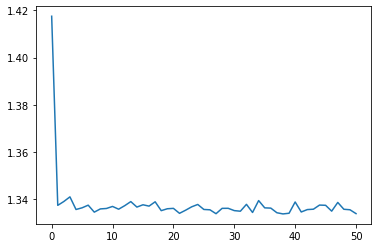

Epoch 1/100
5/5 - 6s - loss: 1.4607 - accuracy: 0.4281 - auc_20: 0.6856 - precision_20: 0.4842 - recall_20: 0.1769 - f1_score: 0.1517 - val_loss: 1.4287 - val_accuracy: 0.4636 - val_auc_20: 0.6904 - val_precision_20: 0.0000e+00 - val_recall_20: 0.0000e+00 - val_f1_score: 0.1267 - 6s/epoch - 1s/step
Epoch 2/100
5/5 - 0s - loss: 1.3464 - accuracy: 0.5207 - auc_20: 0.7282 - precision_20: 0.4928 - recall_20: 0.2843 - f1_score: 0.1370 - val_loss: 1.4222 - val_accuracy: 0.4636 - val_auc_20: 0.7053 - val_precision_20: 0.0000e+00 - val_recall_20: 0.0000e+00 - val_f1_score: 0.1267 - 224ms/epoch - 45ms/step
Epoch 3/100
5/5 - 0s - loss: 1.3396 - accuracy: 0.5207 - auc_20: 0.7347 - precision_20: 0.5199 - recall_20: 0.4099 - f1_score: 0.1370 - val_loss: 1.4290 - val_accuracy: 0.4636 - val_auc_20: 0.6970 - val_precision_20: 0.4636 - val_recall_20: 0.4636 - val_f1_score: 0.1267 - 182ms/epoch - 36ms/step
Epoch 4/100
5/5 - 0s - loss: 1.3423 - accuracy: 0.5207 - auc_20: 0.7305 - precision_20: 0.5220 - r

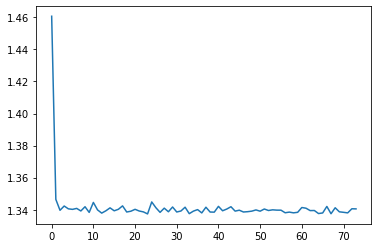

Epoch 1/100
5/5 - 6s - loss: 1.4869 - accuracy: 0.4099 - auc_21: 0.6592 - precision_21: 0.0000e+00 - recall_21: 0.0000e+00 - f1_score: 0.1632 - val_loss: 1.2524 - val_accuracy: 0.5828 - val_auc_21: 0.7864 - val_precision_21: 0.0000e+00 - val_recall_21: 0.0000e+00 - val_f1_score: 0.1473 - 6s/epoch - 1s/step
Epoch 2/100
5/5 - 0s - loss: 1.3836 - accuracy: 0.4909 - auc_21: 0.7181 - precision_21: 0.5294 - recall_21: 0.1934 - f1_score: 0.1317 - val_loss: 1.2383 - val_accuracy: 0.5828 - val_auc_21: 0.7864 - val_precision_21: 0.5828 - val_recall_21: 0.5828 - val_f1_score: 0.1473 - 225ms/epoch - 45ms/step
Epoch 3/100
5/5 - 0s - loss: 1.3912 - accuracy: 0.4909 - auc_21: 0.7094 - precision_21: 0.5039 - recall_21: 0.2132 - f1_score: 0.1317 - val_loss: 1.2461 - val_accuracy: 0.5828 - val_auc_21: 0.7864 - val_precision_21: 0.0000e+00 - val_recall_21: 0.0000e+00 - val_f1_score: 0.1473 - 181ms/epoch - 36ms/step
Epoch 4/100
5/5 - 0s - loss: 1.3927 - accuracy: 0.4909 - auc_21: 0.7058 - precision_21: 0.

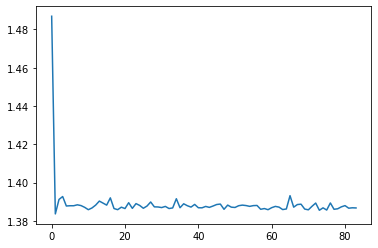

Epoch 1/100
5/5 - 6s - loss: 1.4329 - accuracy: 0.5025 - auc_22: 0.7029 - precision_22: 0.5023 - recall_22: 0.1835 - f1_score: 0.1338 - val_loss: 1.3249 - val_accuracy: 0.5364 - val_auc_22: 0.7384 - val_precision_22: 0.5364 - val_recall_22: 0.5364 - val_f1_score: 0.1397 - 6s/epoch - 1s/step
Epoch 2/100
5/5 - 0s - loss: 1.3669 - accuracy: 0.5025 - auc_22: 0.7233 - precision_22: 0.4814 - recall_22: 0.2777 - f1_score: 0.1338 - val_loss: 1.3265 - val_accuracy: 0.5364 - val_auc_22: 0.7351 - val_precision_22: 0.5364 - val_recall_22: 0.5364 - val_f1_score: 0.1397 - 183ms/epoch - 37ms/step
Epoch 3/100
5/5 - 0s - loss: 1.3626 - accuracy: 0.5025 - auc_22: 0.7300 - precision_22: 0.4974 - recall_22: 0.3157 - f1_score: 0.1338 - val_loss: 1.3284 - val_accuracy: 0.5364 - val_auc_22: 0.7351 - val_precision_22: 0.5364 - val_recall_22: 0.5364 - val_f1_score: 0.1397 - 178ms/epoch - 36ms/step
Epoch 4/100
5/5 - 0s - loss: 1.3705 - accuracy: 0.5025 - auc_22: 0.7240 - precision_22: 0.4922 - recall_22: 0.2083

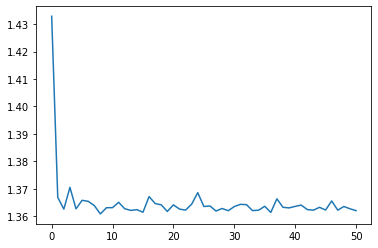

Epoch 1/100
5/5 - 6s - loss: 1.4839 - accuracy: 0.5091 - auc_23: 0.6858 - precision_23: 0.0000e+00 - recall_23: 0.0000e+00 - f1_score: 0.1486 - val_loss: 1.3703 - val_accuracy: 0.4967 - val_auc_23: 0.7260 - val_precision_23: 0.4967 - val_recall_23: 0.4967 - val_f1_score: 0.1327 - 6s/epoch - 1s/step
Epoch 2/100
5/5 - 0s - loss: 1.3555 - accuracy: 0.5124 - auc_23: 0.7273 - precision_23: 0.5130 - recall_23: 0.3256 - f1_score: 0.1355 - val_loss: 1.3762 - val_accuracy: 0.4967 - val_auc_23: 0.7219 - val_precision_23: 0.4967 - val_recall_23: 0.4967 - val_f1_score: 0.1327 - 187ms/epoch - 37ms/step
Epoch 3/100
5/5 - 0s - loss: 1.3570 - accuracy: 0.5124 - auc_23: 0.7285 - precision_23: 0.4906 - recall_23: 0.3868 - f1_score: 0.1355 - val_loss: 1.3711 - val_accuracy: 0.4967 - val_auc_23: 0.7260 - val_precision_23: 0.4967 - val_recall_23: 0.4967 - val_f1_score: 0.1327 - 189ms/epoch - 38ms/step
Epoch 4/100
5/5 - 0s - loss: 1.3539 - accuracy: 0.5124 - auc_23: 0.7307 - precision_23: 0.5182 - recall_23

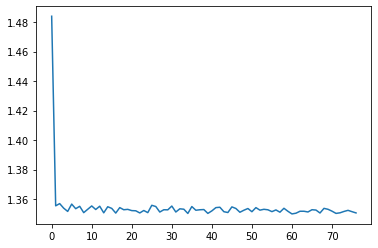

In [45]:
early_cnnlstm_model_path = Path(os.path.abspath('')).parent / 'models' / 'saved' / 'early_cnnlstm.h5'
val_accuracy = 0.0

for train_index, val_index in kf.split(early_X):
    X_train, X_val = early_X[train_index], early_X[val_index]
    y_train, y_val = early_y[train_index], early_y[val_index]
    early_cnnlstm = build_CNNLSTM(early_features, n_length, early_outputs)
    history = train(early_cnnlstm, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        early_cnnlstm.save(early_cnnlstm_model_path)

In [46]:
early_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
early_cnnlstm_train_results

{'Accuracy': 0.509262764453888,
 'ROC/AUC': 0.7290937304496765,
 'Precision': 0.4020000874996185,
 'Recall': 0.28605002760887144,
 'F1-score': 0.13495510220527648}

In [47]:
early_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
early_cnnlstm_val_results

{'Accuracy': 0.5093150973320008,
 'ROC/AUC': 0.72525053024292,
 'Precision': 0.5093150973320008,
 'Recall': 0.5093150973320008,
 'F1-score': 0.13474599719047547}

### Train ConvLSTM (with early fusion)

In [31]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []

In [32]:
early_convLSTM_model_path = Path(os.path.abspath('')).parent / 'models' / 'saved' / 'early_convLSTM.h5'
val_accuracy = 0.0

for train_index, val_index in kf.split(early_X):
    X_train, X_val = early_X[train_index], early_X[val_index]
    y_train, y_val = early_y[train_index], early_y[val_index]
    early_convLSTM = build_convLSTM(early_features, n_length, early_outputs)
    history = train(early_convLSTM, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        early_convLSTM.save(early_convLSTM_model_path)

NameError: name 'build_convLSTM' is not defined

In [ ]:
early_convlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
early_convlstm_train_results

{'Accuracy': 0.4092177629470825,
 'ROC/AUC': 0.6302841186523438,
 'Precision': 0.25739348530769346,
 'Recall': 0.025581394881010057,
 'F1-score': 0.18795897662639618}

In [ ]:
early_convlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
early_convlstm_val_results

{'Accuracy': 0.4041017651557922,
 'ROC/AUC': 0.6217733502388001,
 'Precision': 0.12380952835083008,
 'Recall': 0.005607476457953453,
 'F1-score': 0.17925734221935272}

### Train RCNN (with early fusion)

In [ ]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []

Epoch 1/100
7/7 - 2s - loss: 23.5158 - accuracy: 0.3077 - auc_55: 0.5546 - precision_55: 0.3264 - recall_55: 0.2937 - f1_score: 0.2443 - val_loss: 40.3644 - val_accuracy: 0.2130 - val_auc_55: 0.4891 - val_precision_55: 0.2130 - val_recall_55: 0.2130 - val_f1_score: 0.1325 - 2s/epoch - 220ms/step
Epoch 2/100
7/7 - 0s - loss: 8.6914 - accuracy: 0.2844 - auc_55: 0.5000 - precision_55: 0.2861 - recall_55: 0.2634 - f1_score: 0.2574 - val_loss: 10.2757 - val_accuracy: 0.2407 - val_auc_55: 0.5561 - val_precision_55: 0.2407 - val_recall_55: 0.2407 - val_f1_score: 0.1080 - 145ms/epoch - 21ms/step
Epoch 3/100
7/7 - 0s - loss: 4.3618 - accuracy: 0.3823 - auc_55: 0.5686 - precision_55: 0.3789 - recall_55: 0.3357 - f1_score: 0.2221 - val_loss: 3.7244 - val_accuracy: 0.2870 - val_auc_55: 0.5304 - val_precision_55: 0.4615 - val_recall_55: 0.1111 - val_f1_score: 0.1965 - 122ms/epoch - 17ms/step
Epoch 4/100
7/7 - 0s - loss: 2.8982 - accuracy: 0.2797 - auc_55: 0.5290 - precision_55: 0.2938 - recall_55: 

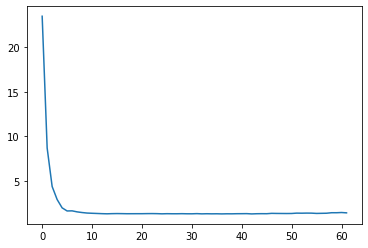

Epoch 1/100
7/7 - 2s - loss: 23.5688 - accuracy: 0.3077 - auc_56: 0.5482 - precision_56: 0.3003 - recall_56: 0.2681 - f1_score: 0.2744 - val_loss: 31.8863 - val_accuracy: 0.3704 - val_auc_56: 0.5688 - val_precision_56: 0.3704 - val_recall_56: 0.3704 - val_f1_score: 0.1680 - 2s/epoch - 220ms/step
Epoch 2/100
7/7 - 0s - loss: 10.2467 - accuracy: 0.3497 - auc_56: 0.5818 - precision_56: 0.3646 - recall_56: 0.3357 - f1_score: 0.2854 - val_loss: 6.2851 - val_accuracy: 0.2222 - val_auc_56: 0.4389 - val_precision_56: 0.2609 - val_recall_56: 0.0556 - val_f1_score: 0.1432 - 126ms/epoch - 18ms/step
Epoch 3/100
7/7 - 0s - loss: 3.9582 - accuracy: 0.3263 - auc_56: 0.5576 - precision_56: 0.3305 - recall_56: 0.2681 - f1_score: 0.2447 - val_loss: 5.2723 - val_accuracy: 0.2222 - val_auc_56: 0.5275 - val_precision_56: 0.2609 - val_recall_56: 0.0556 - val_f1_score: 0.1098 - 122ms/epoch - 17ms/step
Epoch 4/100
7/7 - 0s - loss: 2.6236 - accuracy: 0.3730 - auc_56: 0.5784 - precision_56: 0.2976 - recall_56: 

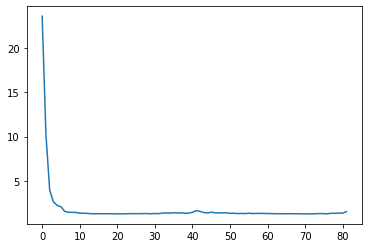

Epoch 1/100
7/7 - 2s - loss: 21.4321 - accuracy: 0.2814 - auc_57: 0.5425 - precision_57: 0.2913 - recall_57: 0.2581 - f1_score: 0.2462 - val_loss: 30.8650 - val_accuracy: 0.2617 - val_auc_57: 0.5822 - val_precision_57: 0.3396 - val_recall_57: 0.1682 - val_f1_score: 0.1303 - 2s/epoch - 219ms/step
Epoch 2/100
7/7 - 0s - loss: 8.5818 - accuracy: 0.2977 - auc_57: 0.5704 - precision_57: 0.2850 - recall_57: 0.2512 - f1_score: 0.2590 - val_loss: 19.7183 - val_accuracy: 0.2430 - val_auc_57: 0.5601 - val_precision_57: 0.3333 - val_recall_57: 0.0841 - val_f1_score: 0.1784 - 128ms/epoch - 18ms/step
Epoch 3/100
7/7 - 0s - loss: 5.5673 - accuracy: 0.3000 - auc_57: 0.5650 - precision_57: 0.3014 - recall_57: 0.3000 - f1_score: 0.2393 - val_loss: 8.4575 - val_accuracy: 0.3458 - val_auc_57: 0.5355 - val_precision_57: 0.1481 - val_recall_57: 0.0374 - val_f1_score: 0.1712 - 125ms/epoch - 18ms/step
Epoch 4/100
7/7 - 0s - loss: 3.0769 - accuracy: 0.2814 - auc_57: 0.5711 - precision_57: 0.3092 - recall_57: 

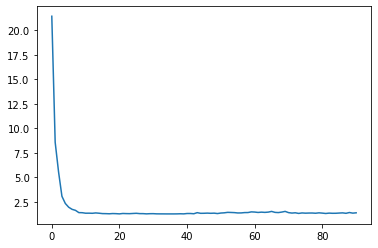

Epoch 1/100
7/7 - 2s - loss: 23.2072 - accuracy: 0.2372 - auc_58: 0.5181 - precision_58: 0.2395 - recall_58: 0.2116 - f1_score: 0.2227 - val_loss: 41.4365 - val_accuracy: 0.2617 - val_auc_58: 0.5505 - val_precision_58: 0.2617 - val_recall_58: 0.2617 - val_f1_score: 0.1875 - 2s/epoch - 221ms/step
Epoch 2/100
7/7 - 0s - loss: 7.4304 - accuracy: 0.3233 - auc_58: 0.5936 - precision_58: 0.3233 - recall_58: 0.3233 - f1_score: 0.2677 - val_loss: 13.4968 - val_accuracy: 0.2710 - val_auc_58: 0.5807 - val_precision_58: 0.3333 - val_recall_58: 0.1028 - val_f1_score: 0.1330 - 125ms/epoch - 18ms/step
Epoch 3/100
7/7 - 0s - loss: 4.8342 - accuracy: 0.3140 - auc_58: 0.5777 - precision_58: 0.3131 - recall_58: 0.1442 - f1_score: 0.2513 - val_loss: 5.8452 - val_accuracy: 0.4019 - val_auc_58: 0.6045 - val_precision_58: 0.3030 - val_recall_58: 0.0935 - val_f1_score: 0.2097 - 124ms/epoch - 18ms/step
Epoch 4/100
7/7 - 0s - loss: 3.2733 - accuracy: 0.3163 - auc_58: 0.5678 - precision_58: 0.3034 - recall_58: 

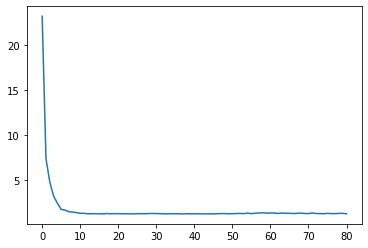

Epoch 1/100
7/7 - 2s - loss: 28.4068 - accuracy: 0.2698 - auc_59: 0.5314 - precision_59: 0.2891 - recall_59: 0.2535 - f1_score: 0.2460 - val_loss: 51.8159 - val_accuracy: 0.2150 - val_auc_59: 0.4483 - val_precision_59: 0.2150 - val_recall_59: 0.2150 - val_f1_score: 0.1176 - 2s/epoch - 224ms/step
Epoch 2/100
7/7 - 0s - loss: 14.0834 - accuracy: 0.3047 - auc_59: 0.5464 - precision_59: 0.2835 - recall_59: 0.2163 - f1_score: 0.2455 - val_loss: 11.7660 - val_accuracy: 0.1215 - val_auc_59: 0.4743 - val_precision_59: 0.2400 - val_recall_59: 0.0561 - val_f1_score: 0.1104 - 123ms/epoch - 18ms/step
Epoch 3/100
7/7 - 0s - loss: 5.7400 - accuracy: 0.2977 - auc_59: 0.5436 - precision_59: 0.2985 - recall_59: 0.2256 - f1_score: 0.2459 - val_loss: 3.6464 - val_accuracy: 0.2617 - val_auc_59: 0.4865 - val_precision_59: 0.2500 - val_recall_59: 0.0374 - val_f1_score: 0.2067 - 123ms/epoch - 18ms/step
Epoch 4/100
7/7 - 0s - loss: 3.6069 - accuracy: 0.2860 - auc_59: 0.5577 - precision_59: 0.3242 - recall_59:

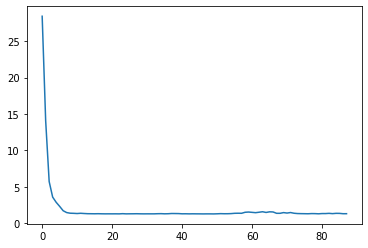

In [ ]:
early_rcnn_model_path = Path(os.path.abspath('')).parent / 'models' / 'saved' / 'early_rcnn.h5'
val_accuracy = 0.0

for train_index, val_index in kf.split(early_X):
    X_train, X_val = early_X[train_index], early_X[val_index]
    y_train, y_val = early_y[train_index], early_y[val_index]
    early_rcnn = build_RCNN(early_features, n_length, early_outputs)
    history = train(early_rcnn, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        early_rcnn.save(early_rcnn_model_path)

In [ ]:
early_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
early_rcnn_train_results

{'Accuracy': 0.4166715443134308,
 'ROC/AUC': 0.6371312618255616,
 'Precision': 0.43756842613220215,
 'Recall': 0.08240581192076206,
 'F1-score': 0.24253758192062377}

In [ ]:
early_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
early_rcnn_val_results

{'Accuracy': 0.3705953598022461,
 'ROC/AUC': 0.5756126761436462,
 'Precision': 0.2130980908870697,
 'Recall': 0.02602976784110069,
 'F1-score': 0.18209434747695924}

## 3. Late Fusion - Fusion is performed at decision level

In late fusion, I test two approaches, in both uni-modal classifiers are trained individually, and then either: 

- Their final dense (decision) layer is concatenated to produce the final prediction; or 

- Ensemble the uni-modal classifiers.

Just as with early fusion, we have the issue that the face modality is missing about half of the times and therefore, I can only use late fusion if both modalities are present.

### About the data

In [ ]:
body_X_train, body_X_test, y_train, y_test = load_latefusion_dataset('processed', 'skeleton')
body_X = body_X_train.copy()
y = y_train.copy()

print(body_X_train.shape, y_train.shape)
print(body_X_test.shape, y_test.shape)

n_length, body_features, body_outputs = body_X_train.shape[2], body_X_train.shape[-1], y_train.shape[1]

(537, 1, 350, 38) (537, 4)
(60, 1, 350, 38) (60, 4)


In [ ]:
umild, lmoderate, lmild, umoderate = np.sum(y_train, axis=0)
total = umild + lmoderate + lmild + umoderate

weight_for_0 = (1 / umild) * (total / 2.0)
weight_for_1 = (1 / lmoderate) * (total / 2.0)
weight_for_2 = (1 / lmild) * (total / 2.0)
weight_for_3 = (1 / umoderate) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3}

### CNN+LSTM (concatenate decision layer)

In [ ]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []

Epoch 1/100
7/7 - 17s - loss: 1.6227 - accuracy: 0.3124 - auc_60: 0.5606 - precision_60: 0.3908 - recall_60: 0.0793 - f1_score: 0.2133 - val_loss: 1.3272 - val_accuracy: 0.3796 - val_auc_60: 0.6425 - val_precision_60: 0.0000e+00 - val_recall_60: 0.0000e+00 - val_f1_score: 0.1376 - 17s/epoch - 2s/step
Epoch 2/100
7/7 - 1s - loss: 1.3579 - accuracy: 0.3846 - auc_60: 0.6093 - precision_60: 0.3158 - recall_60: 0.0280 - f1_score: 0.1926 - val_loss: 1.3566 - val_accuracy: 0.3796 - val_auc_60: 0.6005 - val_precision_60: 0.0000e+00 - val_recall_60: 0.0000e+00 - val_f1_score: 0.1376 - 527ms/epoch - 75ms/step
Epoch 3/100
7/7 - 1s - loss: 1.3251 - accuracy: 0.3986 - auc_60: 0.6357 - precision_60: 0.6154 - recall_60: 0.0373 - f1_score: 0.1710 - val_loss: 1.3092 - val_accuracy: 0.3981 - val_auc_60: 0.6501 - val_precision_60: 0.4286 - val_recall_60: 0.0278 - val_f1_score: 0.2143 - 655ms/epoch - 94ms/step
Epoch 4/100
7/7 - 1s - loss: 1.3185 - accuracy: 0.3776 - auc_60: 0.6425 - precision_60: 0.5556 -

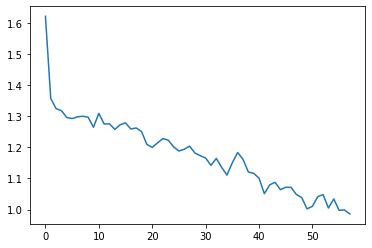

Epoch 1/100
7/7 - 16s - loss: 1.4852 - accuracy: 0.3357 - auc_61: 0.5935 - precision_61: 0.3800 - recall_61: 0.0886 - f1_score: 0.2652 - val_loss: 1.3706 - val_accuracy: 0.3796 - val_auc_61: 0.5901 - val_precision_61: 0.0000e+00 - val_recall_61: 0.0000e+00 - val_f1_score: 0.1376 - 16s/epoch - 2s/step
Epoch 2/100
7/7 - 1s - loss: 1.3180 - accuracy: 0.3869 - auc_61: 0.6458 - precision_61: 0.4878 - recall_61: 0.0466 - f1_score: 0.1826 - val_loss: 1.3601 - val_accuracy: 0.3796 - val_auc_61: 0.6073 - val_precision_61: 0.0000e+00 - val_recall_61: 0.0000e+00 - val_f1_score: 0.1376 - 709ms/epoch - 101ms/step
Epoch 3/100
7/7 - 1s - loss: 1.2972 - accuracy: 0.3869 - auc_61: 0.6597 - precision_61: 0.5714 - recall_61: 0.0746 - f1_score: 0.2628 - val_loss: 1.3866 - val_accuracy: 0.3796 - val_auc_61: 0.5822 - val_precision_61: 0.3902 - val_recall_61: 0.1481 - val_f1_score: 0.1376 - 523ms/epoch - 75ms/step
Epoch 4/100
7/7 - 1s - loss: 1.3377 - accuracy: 0.4056 - auc_61: 0.6315 - precision_61: 0.4691 

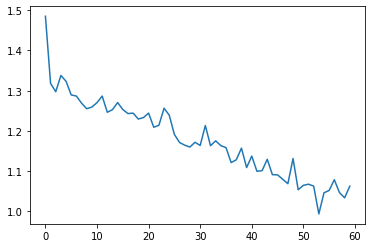

Epoch 1/100
7/7 - 17s - loss: 1.5246 - accuracy: 0.3512 - auc_62: 0.5916 - precision_62: 0.3958 - recall_62: 0.1326 - f1_score: 0.2718 - val_loss: 1.3600 - val_accuracy: 0.3832 - val_auc_62: 0.6051 - val_precision_62: 0.0000e+00 - val_recall_62: 0.0000e+00 - val_f1_score: 0.1385 - 17s/epoch - 2s/step
Epoch 2/100
7/7 - 1s - loss: 1.3415 - accuracy: 0.3628 - auc_62: 0.6295 - precision_62: 0.3434 - recall_62: 0.0791 - f1_score: 0.2160 - val_loss: 1.3829 - val_accuracy: 0.3551 - val_auc_62: 0.5573 - val_precision_62: 0.0000e+00 - val_recall_62: 0.0000e+00 - val_f1_score: 0.2062 - 526ms/epoch - 75ms/step
Epoch 3/100
7/7 - 1s - loss: 1.3243 - accuracy: 0.3581 - auc_62: 0.6422 - precision_62: 0.3000 - recall_62: 0.0209 - f1_score: 0.2405 - val_loss: 1.3653 - val_accuracy: 0.3832 - val_auc_62: 0.6131 - val_precision_62: 0.0000e+00 - val_recall_62: 0.0000e+00 - val_f1_score: 0.1385 - 523ms/epoch - 75ms/step
Epoch 4/100
7/7 - 1s - loss: 1.3114 - accuracy: 0.3930 - auc_62: 0.6493 - precision_62: 

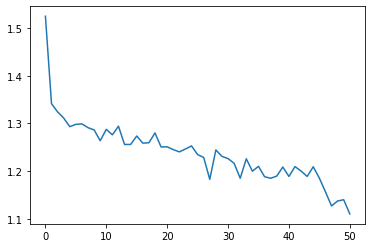

Epoch 1/100
7/7 - 18s - loss: 1.6490 - accuracy: 0.2698 - auc_63: 0.5037 - precision_63: 0.2713 - recall_63: 0.1186 - f1_score: 0.2321 - val_loss: 1.3394 - val_accuracy: 0.3925 - val_auc_63: 0.6214 - val_precision_63: 0.5294 - val_recall_63: 0.1682 - val_f1_score: 0.1409 - 18s/epoch - 3s/step
Epoch 2/100
7/7 - 1s - loss: 1.3280 - accuracy: 0.4070 - auc_63: 0.6339 - precision_63: 0.5432 - recall_63: 0.1023 - f1_score: 0.2369 - val_loss: 1.3176 - val_accuracy: 0.3925 - val_auc_63: 0.6482 - val_precision_63: 0.0000e+00 - val_recall_63: 0.0000e+00 - val_f1_score: 0.1409 - 679ms/epoch - 97ms/step
Epoch 3/100
7/7 - 1s - loss: 1.3242 - accuracy: 0.3860 - auc_63: 0.6345 - precision_63: 0.3889 - recall_63: 0.0326 - f1_score: 0.2027 - val_loss: 1.3343 - val_accuracy: 0.3925 - val_auc_63: 0.6181 - val_precision_63: 0.0000e+00 - val_recall_63: 0.0000e+00 - val_f1_score: 0.1409 - 548ms/epoch - 78ms/step
Epoch 4/100
7/7 - 1s - loss: 1.3326 - accuracy: 0.4047 - auc_63: 0.6302 - precision_63: 0.4318 -

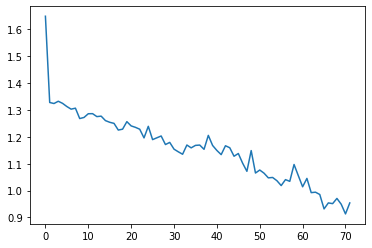

Epoch 1/100
7/7 - 19s - loss: 1.5749 - accuracy: 0.2651 - auc_64: 0.5170 - precision_64: 0.2800 - recall_64: 0.0977 - f1_score: 0.2241 - val_loss: 1.4281 - val_accuracy: 0.1308 - val_auc_64: 0.4653 - val_precision_64: 0.0000e+00 - val_recall_64: 0.0000e+00 - val_f1_score: 0.0764 - 19s/epoch - 3s/step
Epoch 2/100
7/7 - 1s - loss: 1.3390 - accuracy: 0.3605 - auc_64: 0.6217 - precision_64: 0.5294 - recall_64: 0.0209 - f1_score: 0.2152 - val_loss: 1.2816 - val_accuracy: 0.4486 - val_auc_64: 0.6580 - val_precision_64: 0.5714 - val_recall_64: 0.0374 - val_f1_score: 0.1548 - 733ms/epoch - 105ms/step
Epoch 3/100
7/7 - 1s - loss: 1.3414 - accuracy: 0.3814 - auc_64: 0.6260 - precision_64: 0.4286 - recall_64: 0.0349 - f1_score: 0.2039 - val_loss: 1.3168 - val_accuracy: 0.4486 - val_auc_64: 0.6519 - val_precision_64: 0.0000e+00 - val_recall_64: 0.0000e+00 - val_f1_score: 0.1713 - 564ms/epoch - 81ms/step
Epoch 4/100
7/7 - 1s - loss: 1.3321 - accuracy: 0.3581 - auc_64: 0.6323 - precision_64: 0.5185 

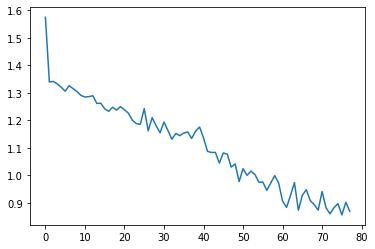

In [ ]:
late_cnnlstm_model_path = Path(os.path.abspath('')).parent / 'models' / 'saved' / 'late_cnnlstm.h5'
val_accuracy = 0.0

for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    head_X_train, head_X_val = head_X[train_index], head_X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    late_cnnlstm = build_fusioned_CNNLSTM(body_features, face_features, head_features, n_length, body_outputs)
    history = train_fusioned(late_cnnlstm, body_X_train, face_X_train, head_X_train, y_train, body_X_val, face_X_val, head_X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        late_cnnlstm.save(late_cnnlstm_model_path)

In [ ]:
late_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
late_cnnlstm_train_results

{'Accuracy': 0.5553932785987854,
 'ROC/AUC': 0.8166073799133301,
 'Precision': 0.7051610231399537,
 'Recall': 0.3724410444498062,
 'F1-score': 0.5182024002075195}

In [ ]:
late_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
late_cnnlstm_val_results

{'Accuracy': 0.38181031346321104,
 'ROC/AUC': 0.6287647247314453,
 'Precision': 0.38728187084197996,
 'Recall': 0.28520249128341674,
 'F1-score': 0.22745672166347503}

### ConvLSTM (concatenate decision layer)

In [ ]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []

Epoch 1/100
7/7 - 29s - loss: 3.5659 - accuracy: 0.2960 - auc_65: 0.5462 - precision_65: 0.3198 - recall_65: 0.2564 - f1_score: 0.2241 - val_loss: 1.5935 - val_accuracy: 0.3611 - val_auc_65: 0.6176 - val_precision_65: 0.3654 - val_recall_65: 0.1759 - val_f1_score: 0.1998 - 29s/epoch - 4s/step
Epoch 2/100
7/7 - 2s - loss: 1.5865 - accuracy: 0.3333 - auc_65: 0.5850 - precision_65: 0.2500 - recall_65: 0.0769 - f1_score: 0.2550 - val_loss: 1.3963 - val_accuracy: 0.3889 - val_auc_65: 0.6519 - val_precision_65: 0.3636 - val_recall_65: 0.0741 - val_f1_score: 0.2309 - 2s/epoch - 312ms/step
Epoch 3/100
7/7 - 2s - loss: 1.4073 - accuracy: 0.3217 - auc_65: 0.5961 - precision_65: 0.4405 - recall_65: 0.0862 - f1_score: 0.2419 - val_loss: 1.6121 - val_accuracy: 0.3796 - val_auc_65: 0.5355 - val_precision_65: 0.5833 - val_recall_65: 0.0648 - val_f1_score: 0.1376 - 2s/epoch - 292ms/step
Epoch 4/100
7/7 - 2s - loss: 1.4381 - accuracy: 0.3333 - auc_65: 0.6017 - precision_65: 0.4110 - recall_65: 0.1399 -

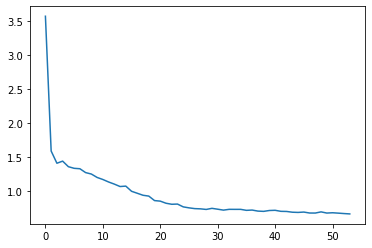

Epoch 1/100
7/7 - 27s - loss: 3.6222 - accuracy: 0.2308 - auc_66: 0.5273 - precision_66: 0.2397 - recall_66: 0.1772 - f1_score: 0.1913 - val_loss: 1.5416 - val_accuracy: 0.3889 - val_auc_66: 0.6249 - val_precision_66: 0.3922 - val_recall_66: 0.1852 - val_f1_score: 0.1612 - 27s/epoch - 4s/step
Epoch 2/100
7/7 - 2s - loss: 1.6099 - accuracy: 0.3357 - auc_66: 0.5622 - precision_66: 0.3422 - recall_66: 0.1492 - f1_score: 0.2547 - val_loss: 1.5823 - val_accuracy: 0.3241 - val_auc_66: 0.5894 - val_precision_66: 0.3370 - val_recall_66: 0.2870 - val_f1_score: 0.2272 - 2s/epoch - 293ms/step
Epoch 3/100
7/7 - 2s - loss: 1.5592 - accuracy: 0.3357 - auc_66: 0.5855 - precision_66: 0.3652 - recall_66: 0.1958 - f1_score: 0.2343 - val_loss: 1.4181 - val_accuracy: 0.2315 - val_auc_66: 0.5471 - val_precision_66: 0.0000e+00 - val_recall_66: 0.0000e+00 - val_f1_score: 0.1335 - 2s/epoch - 306ms/step
Epoch 4/100
7/7 - 2s - loss: 1.3531 - accuracy: 0.3660 - auc_66: 0.6542 - precision_66: 0.4386 - recall_66: 

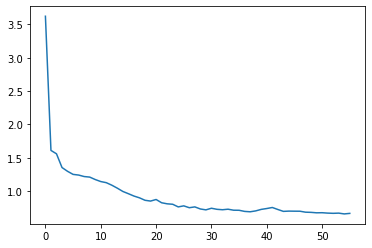

Epoch 1/100
7/7 - 28s - loss: 3.1794 - accuracy: 0.3140 - auc_67: 0.5732 - precision_67: 0.3020 - recall_67: 0.2465 - f1_score: 0.2206 - val_loss: 2.4337 - val_accuracy: 0.3832 - val_auc_67: 0.6093 - val_precision_67: 0.3832 - val_recall_67: 0.3832 - val_f1_score: 0.1686 - 28s/epoch - 4s/step
Epoch 2/100
7/7 - 2s - loss: 1.6282 - accuracy: 0.3000 - auc_67: 0.5943 - precision_67: 0.3128 - recall_67: 0.1419 - f1_score: 0.2561 - val_loss: 1.4667 - val_accuracy: 0.3925 - val_auc_67: 0.6131 - val_precision_67: 0.3846 - val_recall_67: 0.0935 - val_f1_score: 0.1631 - 2s/epoch - 311ms/step
Epoch 3/100
7/7 - 2s - loss: 1.3723 - accuracy: 0.3884 - auc_67: 0.6374 - precision_67: 0.4912 - recall_67: 0.1302 - f1_score: 0.2352 - val_loss: 1.3835 - val_accuracy: 0.2710 - val_auc_67: 0.5564 - val_precision_67: 0.2000 - val_recall_67: 0.0187 - val_f1_score: 0.2263 - 2s/epoch - 301ms/step
Epoch 4/100
7/7 - 2s - loss: 1.3280 - accuracy: 0.3512 - auc_67: 0.6329 - precision_67: 0.5349 - recall_67: 0.1070 -

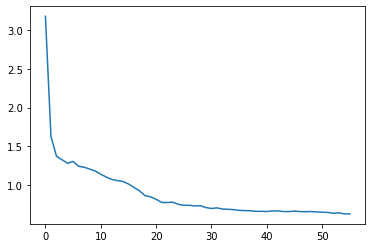

Epoch 1/100
7/7 - 28s - loss: 2.9889 - accuracy: 0.3279 - auc_68: 0.5907 - precision_68: 0.3133 - recall_68: 0.2186 - f1_score: 0.2350 - val_loss: 1.3224 - val_accuracy: 0.3364 - val_auc_68: 0.6628 - val_precision_68: 0.0000e+00 - val_recall_68: 0.0000e+00 - val_f1_score: 0.1822 - 28s/epoch - 4s/step
Epoch 2/100
7/7 - 2s - loss: 1.4139 - accuracy: 0.3651 - auc_68: 0.5978 - precision_68: 0.2632 - recall_68: 0.0349 - f1_score: 0.2529 - val_loss: 1.4375 - val_accuracy: 0.3178 - val_auc_68: 0.5994 - val_precision_68: 0.4286 - val_recall_68: 0.0280 - val_f1_score: 0.2013 - 2s/epoch - 293ms/step
Epoch 3/100
7/7 - 2s - loss: 1.3614 - accuracy: 0.3721 - auc_68: 0.6198 - precision_68: 0.6136 - recall_68: 0.0628 - f1_score: 0.2687 - val_loss: 1.2759 - val_accuracy: 0.3832 - val_auc_68: 0.6704 - val_precision_68: 0.6190 - val_recall_68: 0.1215 - val_f1_score: 0.1864 - 2s/epoch - 300ms/step
Epoch 4/100
7/7 - 2s - loss: 1.2820 - accuracy: 0.4093 - auc_68: 0.6769 - precision_68: 0.4819 - recall_68: 

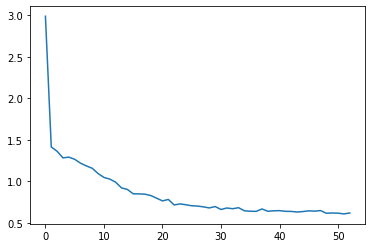

Epoch 1/100
7/7 - 28s - loss: 3.4545 - accuracy: 0.2860 - auc_69: 0.5660 - precision_69: 0.3100 - recall_69: 0.2372 - f1_score: 0.2312 - val_loss: 1.5978 - val_accuracy: 0.4486 - val_auc_69: 0.6638 - val_precision_69: 0.4528 - val_recall_69: 0.4486 - val_f1_score: 0.1548 - 28s/epoch - 4s/step
Epoch 2/100
7/7 - 2s - loss: 1.5790 - accuracy: 0.3140 - auc_69: 0.5946 - precision_69: 0.3333 - recall_69: 0.1535 - f1_score: 0.2967 - val_loss: 1.4443 - val_accuracy: 0.4486 - val_auc_69: 0.6677 - val_precision_69: 0.5132 - val_recall_69: 0.3645 - val_f1_score: 0.1548 - 2s/epoch - 311ms/step
Epoch 3/100
7/7 - 2s - loss: 1.4451 - accuracy: 0.3512 - auc_69: 0.6220 - precision_69: 0.4498 - recall_69: 0.2814 - f1_score: 0.2050 - val_loss: 1.5301 - val_accuracy: 0.2430 - val_auc_69: 0.4885 - val_precision_69: 0.3043 - val_recall_69: 0.0654 - val_f1_score: 0.1208 - 2s/epoch - 294ms/step
Epoch 4/100
7/7 - 2s - loss: 1.4324 - accuracy: 0.2907 - auc_69: 0.6023 - precision_69: 0.3750 - recall_69: 0.1535 -

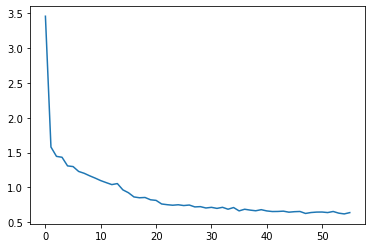

In [ ]:
late_convlstm_model_path = Path(os.path.abspath('')).parent / 'models' / 'saved' / 'late_convlstm.h5'
val_accuracy = 0.0

for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    head_X_train, head_X_val = head_X[train_index], head_X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    late_convlstm = build_fusioned_convLSTM(body_features, face_features, head_features, n_length, body_outputs)
    history = train_fusioned(late_convlstm, body_X_train, face_X_train, head_X_train, y_train, body_X_val, face_X_val, head_X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        late_convlstm.save(late_convlstm_model_path)

In [ ]:
late_convlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
late_convlstm_train_results

{'Accuracy': 0.6727012395858765,
 'ROC/AUC': 0.9150859594345093,
 'Precision': 0.8649007558822632,
 'Recall': 0.5470114350318909,
 'F1-score': 0.660550880432129}

In [ ]:
late_convlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
late_convlstm_val_results

{'Accuracy': 0.398615425825119,
 'ROC/AUC': 0.6321725487709046,
 'Precision': 0.4315493702888489,
 'Recall': 0.2645379066467285,
 'F1-score': 0.3110325574874878}

### RCNN (concatenate decision layer)

In [ ]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []

Epoch 1/100
7/7 - 4s - loss: 13.8257 - accuracy: 0.2797 - auc_70: 0.5324 - precision_70: 0.2946 - recall_70: 0.2657 - f1_score: 0.2311 - val_loss: 59.1546 - val_accuracy: 0.3611 - val_auc_70: 0.5826 - val_precision_70: 0.3611 - val_recall_70: 0.3611 - val_f1_score: 0.1383 - 4s/epoch - 514ms/step
Epoch 2/100
7/7 - 0s - loss: 4.4851 - accuracy: 0.3800 - auc_70: 0.6120 - precision_70: 0.3826 - recall_70: 0.3683 - f1_score: 0.3663 - val_loss: 15.1479 - val_accuracy: 0.2315 - val_auc_70: 0.4844 - val_precision_70: 0.2315 - val_recall_70: 0.2315 - val_f1_score: 0.0940 - 336ms/epoch - 48ms/step
Epoch 3/100
7/7 - 0s - loss: 3.8033 - accuracy: 0.4103 - auc_70: 0.6608 - precision_70: 0.4357 - recall_70: 0.3869 - f1_score: 0.3867 - val_loss: 9.6587 - val_accuracy: 0.1944 - val_auc_70: 0.5183 - val_precision_70: 0.1905 - val_recall_70: 0.1852 - val_f1_score: 0.1048 - 341ms/epoch - 49ms/step
Epoch 4/100
7/7 - 0s - loss: 2.2596 - accuracy: 0.4522 - auc_70: 0.7102 - precision_70: 0.4673 - recall_70: 

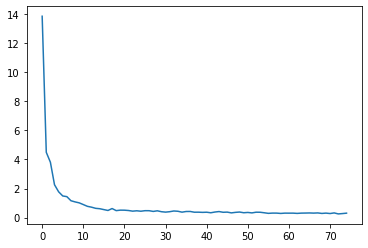

Epoch 1/100
7/7 - 4s - loss: 6.8096 - accuracy: 0.3054 - auc_71: 0.5392 - precision_71: 0.2985 - recall_71: 0.2727 - f1_score: 0.2641 - val_loss: 71.5394 - val_accuracy: 0.1944 - val_auc_71: 0.4630 - val_precision_71: 0.1944 - val_recall_71: 0.1944 - val_f1_score: 0.0814 - 4s/epoch - 515ms/step
Epoch 2/100
7/7 - 0s - loss: 4.3284 - accuracy: 0.4009 - auc_71: 0.6492 - precision_71: 0.3981 - recall_71: 0.3869 - f1_score: 0.3703 - val_loss: 7.4978 - val_accuracy: 0.3611 - val_auc_71: 0.5886 - val_precision_71: 0.3611 - val_recall_71: 0.3611 - val_f1_score: 0.1821 - 333ms/epoch - 48ms/step
Epoch 3/100
7/7 - 0s - loss: 2.6841 - accuracy: 0.4825 - auc_71: 0.7195 - precision_71: 0.4936 - recall_71: 0.4522 - f1_score: 0.4425 - val_loss: 27.1756 - val_accuracy: 0.2037 - val_auc_71: 0.4691 - val_precision_71: 0.2037 - val_recall_71: 0.2037 - val_f1_score: 0.0846 - 282ms/epoch - 40ms/step
Epoch 4/100
7/7 - 0s - loss: 2.3489 - accuracy: 0.5105 - auc_71: 0.7516 - precision_71: 0.5165 - recall_71: 0

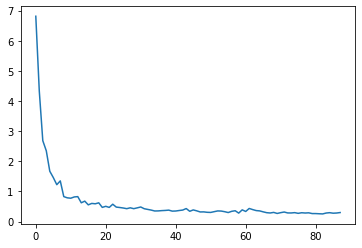

Epoch 1/100
7/7 - 4s - loss: 12.4310 - accuracy: 0.2930 - auc_72: 0.5288 - precision_72: 0.2743 - recall_72: 0.2558 - f1_score: 0.2468 - val_loss: 30.3727 - val_accuracy: 0.3832 - val_auc_72: 0.5877 - val_precision_72: 0.3832 - val_recall_72: 0.3832 - val_f1_score: 0.1768 - 4s/epoch - 512ms/step
Epoch 2/100
7/7 - 0s - loss: 3.1892 - accuracy: 0.4000 - auc_72: 0.6550 - precision_72: 0.3932 - recall_72: 0.3512 - f1_score: 0.3437 - val_loss: 17.1194 - val_accuracy: 0.3551 - val_auc_72: 0.5676 - val_precision_72: 0.3551 - val_recall_72: 0.3551 - val_f1_score: 0.1517 - 341ms/epoch - 49ms/step
Epoch 3/100
7/7 - 0s - loss: 2.5321 - accuracy: 0.4581 - auc_72: 0.7151 - precision_72: 0.4740 - recall_72: 0.4233 - f1_score: 0.4348 - val_loss: 10.4256 - val_accuracy: 0.3925 - val_auc_72: 0.5812 - val_precision_72: 0.3925 - val_recall_72: 0.3925 - val_f1_score: 0.1580 - 338ms/epoch - 48ms/step
Epoch 4/100
7/7 - 0s - loss: 1.7807 - accuracy: 0.5326 - auc_72: 0.7679 - precision_72: 0.5559 - recall_72:

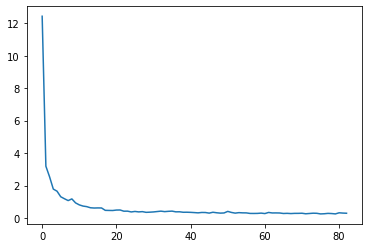

Epoch 1/100
7/7 - 4s - loss: 10.2339 - accuracy: 0.3070 - auc_73: 0.5449 - precision_73: 0.2891 - recall_73: 0.2535 - f1_score: 0.2533 - val_loss: 29.5385 - val_accuracy: 0.2617 - val_auc_73: 0.5078 - val_precision_73: 0.2617 - val_recall_73: 0.2617 - val_f1_score: 0.1272 - 4s/epoch - 513ms/step
Epoch 2/100
7/7 - 0s - loss: 3.4286 - accuracy: 0.4093 - auc_73: 0.6507 - precision_73: 0.4126 - recall_73: 0.3953 - f1_score: 0.3750 - val_loss: 14.5141 - val_accuracy: 0.1963 - val_auc_73: 0.4642 - val_precision_73: 0.1963 - val_recall_73: 0.1963 - val_f1_score: 0.1062 - 325ms/epoch - 46ms/step
Epoch 3/100
7/7 - 0s - loss: 2.1575 - accuracy: 0.4558 - auc_73: 0.6986 - precision_73: 0.4835 - recall_73: 0.4093 - f1_score: 0.4364 - val_loss: 4.6885 - val_accuracy: 0.3832 - val_auc_73: 0.6171 - val_precision_73: 0.3900 - val_recall_73: 0.3645 - val_f1_score: 0.1978 - 332ms/epoch - 47ms/step
Epoch 4/100
7/7 - 0s - loss: 1.8006 - accuracy: 0.4977 - auc_73: 0.7312 - precision_73: 0.5201 - recall_73: 

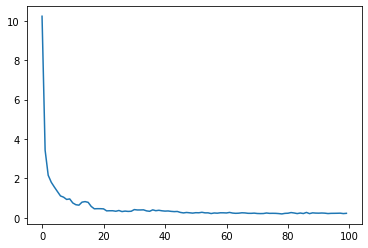

Epoch 1/100
7/7 - 4s - loss: 14.1077 - accuracy: 0.3140 - auc_74: 0.5607 - precision_74: 0.3130 - recall_74: 0.2860 - f1_score: 0.2824 - val_loss: 31.6835 - val_accuracy: 0.1963 - val_auc_74: 0.4642 - val_precision_74: 0.1963 - val_recall_74: 0.1963 - val_f1_score: 0.1088 - 4s/epoch - 513ms/step
Epoch 2/100
7/7 - 0s - loss: 3.6517 - accuracy: 0.3651 - auc_74: 0.6179 - precision_74: 0.3706 - recall_74: 0.3395 - f1_score: 0.3527 - val_loss: 10.1297 - val_accuracy: 0.1963 - val_auc_74: 0.4632 - val_precision_74: 0.1963 - val_recall_74: 0.1963 - val_f1_score: 0.1088 - 338ms/epoch - 48ms/step
Epoch 3/100
7/7 - 0s - loss: 2.4577 - accuracy: 0.4372 - auc_74: 0.6848 - precision_74: 0.4603 - recall_74: 0.4047 - f1_score: 0.4034 - val_loss: 10.7482 - val_accuracy: 0.1776 - val_auc_74: 0.4187 - val_precision_74: 0.1776 - val_recall_74: 0.1776 - val_f1_score: 0.0754 - 283ms/epoch - 40ms/step
Epoch 4/100
7/7 - 0s - loss: 1.4800 - accuracy: 0.5465 - auc_74: 0.7805 - precision_74: 0.5664 - recall_74:

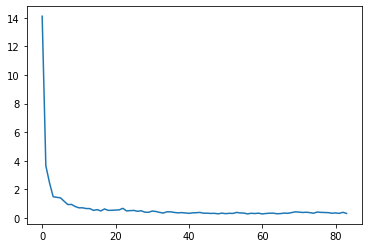

In [ ]:
late_rcnn_model_path = Path(os.path.abspath('')).parent / 'models' / 'saved' / 'late_rcnn.h5'
val_accuracy = 0.0

for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    head_X_train, head_X_val = head_X[train_index], head_X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    late_rcnn = build_fusioned_RCNN(body_features, face_features, head_features, n_length, body_outputs)
    history = train_fusioned(late_rcnn, body_X_train, face_X_train, head_X_train, y_train, body_X_val, face_X_val, head_X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        late_rcnn.save(late_rcnn_model_path)

In [ ]:
late_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
late_rcnn_train_results

{'Accuracy': 0.8659175038337708,
 'ROC/AUC': 0.9841941118240356,
 'Precision': 0.8715099692344666,
 'Recall': 0.8584658741950989,
 'F1-score': 0.8585541009902954}

In [ ]:
late_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
late_rcnn_val_results

{'Accuracy': 0.37796815633773806,
 'ROC/AUC': 0.629546844959259,
 'Precision': 0.3912602186203003,
 'Recall': 0.3518864631652832,
 'F1-score': 0.3169832110404968}

### Dirichlet Markov Ensemble with weighted soft voting

In [ ]:
cnn_body_member = KerasMember(name="CNN+Bidirectional LSTM Body Model", keras_model=body_cnnlstm, train_batches=(body_X_train, y_train), val_batches=(body_X_test, y_test))
cnn_face_member = KerasMember(name="CNN+Bidirectional LSTM Face Model", keras_model=face_cnnlstm, train_batches=(face_X_train, y_train), val_batches=(face_X_test, y_test))
cnn_head_member = KerasMember(name="CNN+Bidirectional LSTM Head Model", keras_model=head_cnnlstm, train_batches=(head_X_train, y_train), val_batches=(head_X_test, y_test))
convLSTM_body_member = KerasMember(name="ConvLSTM Body Model", keras_model=body_convLSTM, train_batches=(body_X_train, y_train), val_batches=(body_X_test, y_test))
convLSTM_face_member = KerasMember(name="ConvLSTM Face Model", keras_model=face_convLSTM, train_batches=(face_X_train, y_train), val_batches=(face_X_test, y_test))
convLSTM_head_member = KerasMember(name="ConvLSTM Head Model", keras_model=head_convLSTM, train_batches=(head_X_train, y_train), val_batches=(head_X_test, y_test))
rcnn_body_member = KerasMember(name="RCNN Body Model", keras_model=body_rcnn, train_batches=(body_X_train, y_train), val_batches=(body_X_test, y_test))
rcnn_face_member = KerasMember(name="RCNN Face Model", keras_model=face_rcnn, train_batches=(face_X_train, y_train), val_batches=(face_X_test, y_test))
rcnn_head_member = KerasMember(name="RCNN Head Model", keras_model=head_rcnn, train_batches=(head_X_train, y_train), val_batches=(head_X_test, y_test))

In [ ]:
dirichletEnsemble = DirichletEnsemble()
dirichletEnsemble.add_member(cnn_body_member)
dirichletEnsemble.add_member(cnn_face_member)
dirichletEnsemble.add_member(cnn_head_member)
dirichletEnsemble.add_member(convLSTM_body_member)
dirichletEnsemble.add_member(convLSTM_face_member)
dirichletEnsemble.add_member(convLSTM_head_member)
dirichletEnsemble.add_member(rcnn_body_member)
dirichletEnsemble.add_member(rcnn_face_member)
dirichletEnsemble.add_member(rcnn_head_member)
dirichletEnsemble.fit()

## Performance Evaluation on Test set

### Uni-Modal Body (skeleton data)

In [27]:
body_cnnlstm = tf.keras.models.load_model(body_cnnlstm_model_path)
y_pred = body_cnnlstm.predict(full_body_X_test)

In [30]:
_, acc, auc, precision, recall, f1 = body_cnnlstm.evaluate(full_body_X_test, full_body_y_test, verbose=0)
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Accuracy: 56.77% 
ROC/AUC: 0.61 
Precision: 0.88 
Recall: 0.57 
F1 score: 0.92


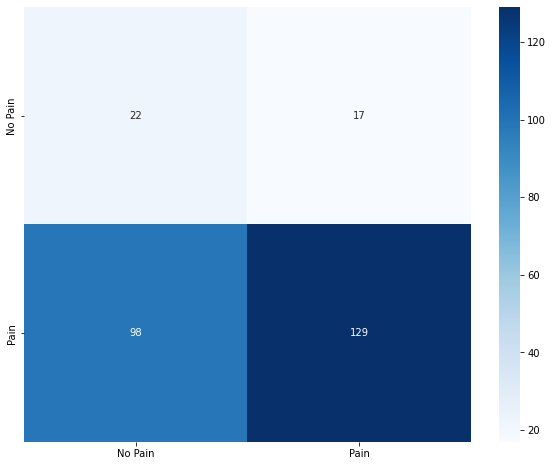

In [35]:
labels = ['No Pain', 'Pain']    

fig, ax = plt.subplots(figsize=(10,8))

y_pred = np.where(y_pred > 0.5, 1, 0)
cm = confusion_matrix(full_body_y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues)

ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels)
plt.show()

In [ ]:
body_convLSTM = tf.keras.models.load_model(body_convlstm_model_path)
y_pred = body_convLSTM.predict(full_body_X_test)

In [ ]:
_, acc, auc, precision, recall, f1 = body_cnnlstm.evaluate(full_body_X_test, full_body_y_test, verbose=0)
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Accuracy: 14.66% 
Balanced Accuracy: 20.00% 
ROC/AUC: 0.56 
Precision: 0.15 
Recall: 0.15 
F1 score: 0.05


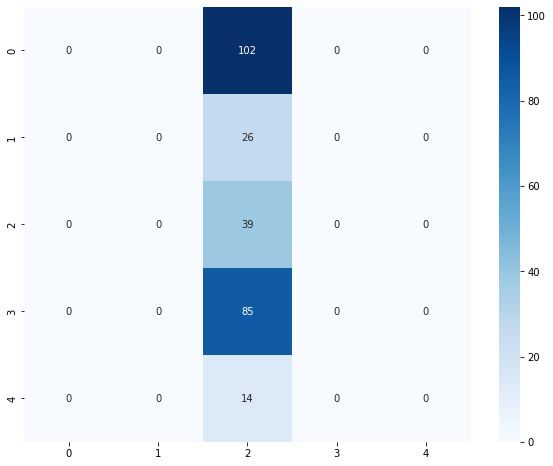

In [ ]:
labels = ['No Pain', 'Pain']    

fig, ax = plt.subplots(figsize=(10,8))

y_pred = np.where(y_pred > 0.5, 1, 0)
cm = confusion_matrix(full_body_y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues)

ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels)
plt.show()

In [ ]:
body_rcnn = tf.keras.models.load_model(body_rcnn_model_path)
y_pred = body_rcnn.predict(full_body_X_test)

In [ ]:
_, acc, auc, precision, recall, f1 = body_rcnn.evaluate(full_body_X_test, full_body_y_test, verbose=0)
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Accuracy: 18.05% 
Balanced Accuracy: 17.96% 
ROC/AUC: 0.50 
Precision: 0.18 
Recall: 0.16 
F1 score: 0.10


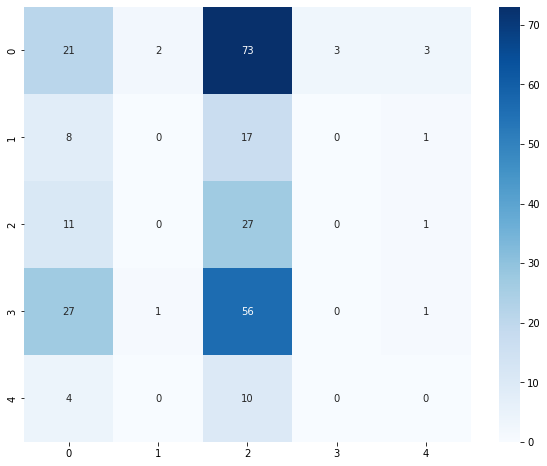

In [ ]:
labels = ['No Pain', 'Pain']    

fig, ax = plt.subplots(figsize=(10,8))

y_pred = np.where(y_pred > 0.5, 1, 0)
cm = confusion_matrix(full_body_y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues)

ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels)
plt.show()

### Uni-Modal Face (action units)

In [ ]:
face_cnnlstm = tf.keras.models.load_model(face_cnnlstm_model_path)
y_pred = face_cnnlstm.predict(face_X_test)
i = 0
for pred in y_pred:
    index = np.argmax(pred)
    tmp = np.array([0, 0, 0, 0])
    tmp[index] = 1
    y_pred[i] = tmp
    i += 1
y_pred = y_pred.astype(int)

In [ ]:
_, acc, auc, precision, recall, f1 = face_cnnlstm.evaluate(face_X_test, face_y_test, verbose=0)
bal_acc = balanced_accuracy_score(face_y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 36.67% 
Balanced Accuracy: 22.47% 
ROC/AUC: 0.70 
Precision: 0.50 
Recall: 0.22 
F1 score: 0.17


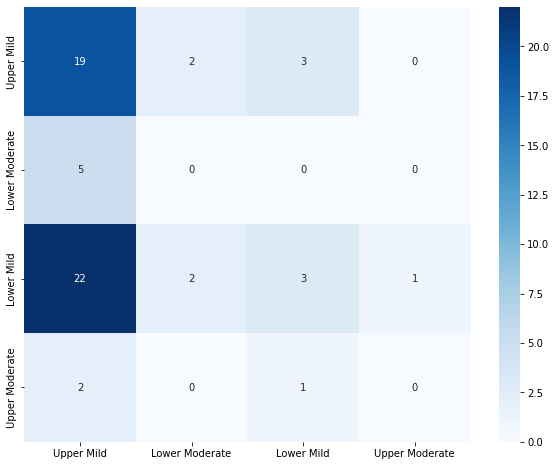

In [ ]:
labels = ['Upper Mild', 'Lower Moderate', 'Lower Mild','Upper Moderate']    

fig, ax = plt.subplots(figsize=(10,8))

cm = confusion_matrix(face_y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues)

ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels)
plt.show()

In [ ]:
face_convLSTM = tf.keras.models.load_model(face_convlstm_model_path)
y_pred = face_convLSTM.predict(face_X_test)
i = 0
for pred in y_pred:
    index = np.argmax(pred)
    tmp = np.array([0, 0, 0, 0])
    tmp[index] = 1
    y_pred[i] = tmp
    i += 1
y_pred = y_pred.astype(int)

In [ ]:
_, acc, auc, precision, recall, f1 = face_convLSTM.evaluate(face_X_test, face_y_test, verbose=0)
bal_acc = balanced_accuracy_score(face_y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 40.00% 
Balanced Accuracy: 25.00% 
ROC/AUC: 0.62 
Precision: 0.60 
Recall: 0.15 
F1 score: 0.14


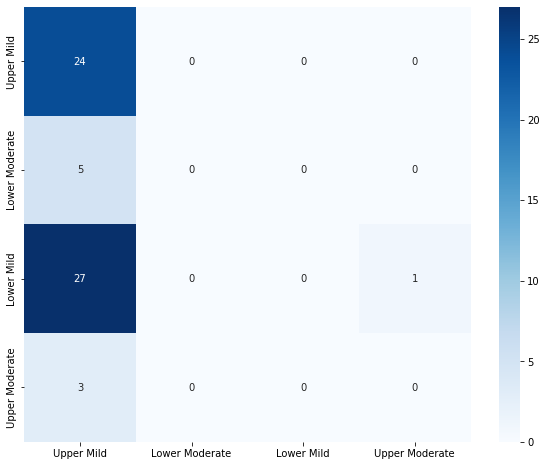

In [ ]:
labels = ['Upper Mild', 'Lower Moderate', 'Lower Mild','Upper Moderate']    

fig, ax = plt.subplots(figsize=(10,8))

cm = confusion_matrix(face_y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues)

ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels)
plt.show()

In [ ]:
face_rcnn = tf.keras.models.load_model(face_rcnn_model_path)
y_pred = face_rcnn.predict(face_X_test)
i = 0
for pred in y_pred:
    index = np.argmax(pred)
    tmp = np.array([0, 0, 0, 0])
    tmp[index] = 1
    y_pred[i] = tmp
    i += 1
y_pred = y_pred.astype(int)

In [ ]:
_, acc, auc, precision, recall, f1 = face_rcnn.evaluate(face_X_test, face_y_test, verbose=0)
bal_acc = balanced_accuracy_score(face_y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 55.00% 
Balanced Accuracy: 40.06% 
ROC/AUC: 0.70 
Precision: 0.45 
Recall: 0.28 
F1 score: 0.37


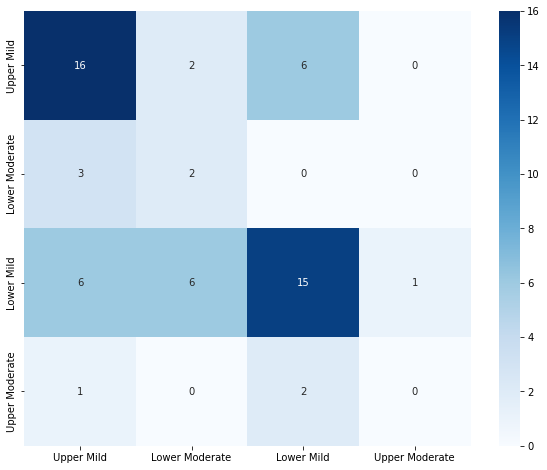

In [ ]:
labels = ['Upper Mild', 'Lower Moderate', 'Lower Mild','Upper Moderate']    

fig, ax = plt.subplots(figsize=(10,8))

cm = confusion_matrix(face_y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues)

ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels)
plt.show()

### Uni-modal Head (pose)

In [ ]:
head_cnnlstm = tf.keras.models.load_model(head_cnnlstm_model_path)
y_pred = head_cnnlstm.predict(head_X_test)
i = 0
for pred in y_pred:
    index = np.argmax(pred)
    tmp = np.array([0, 0, 0, 0])
    tmp[index] = 1
    y_pred[i] = tmp
    i += 1
y_pred = y_pred.astype(int)

In [ ]:
_, acc, auc, precision, recall, f1 = head_cnnlstm.evaluate(head_X_test, head_y_test, verbose=0)
bal_acc = balanced_accuracy_score(head_y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 40.00% 
Balanced Accuracy: 25.00% 
ROC/AUC: 0.74 
Precision: 0.00 
Recall: 0.00 
F1 score: 0.14


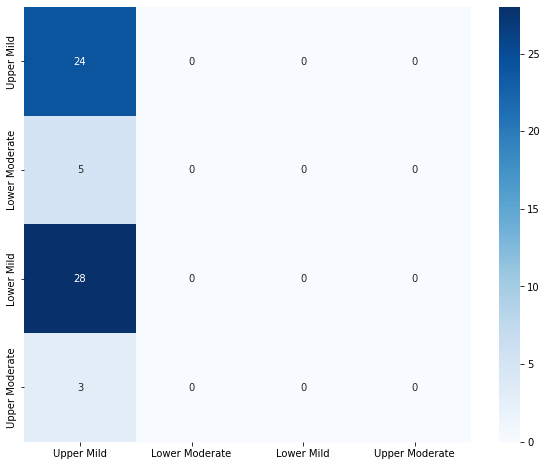

In [ ]:
labels = ['Upper Mild', 'Lower Moderate', 'Lower Mild','Upper Moderate']    

fig, ax = plt.subplots(figsize=(10,8))

cm = confusion_matrix(head_y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues)

ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels)
plt.show()

In [ ]:
head_convLSTM = tf.keras.models.load_model(head_convLSTM_model_path)
y_pred = head_convLSTM.predict(head_X_test)
i = 0
for pred in y_pred:
    index = np.argmax(pred)
    tmp = np.array([0, 0, 0, 0])
    tmp[index] = 1
    y_pred[i] = tmp
    i += 1
y_pred = y_pred.astype(int)

In [ ]:
_, acc, auc, precision, recall, f1 = head_convLSTM.evaluate(head_X_test, head_y_test, verbose=0)
bal_acc = balanced_accuracy_score(head_y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 40.00% 
Balanced Accuracy: 25.00% 
ROC/AUC: 0.74 
Precision: 0.00 
Recall: 0.00 
F1 score: 0.14


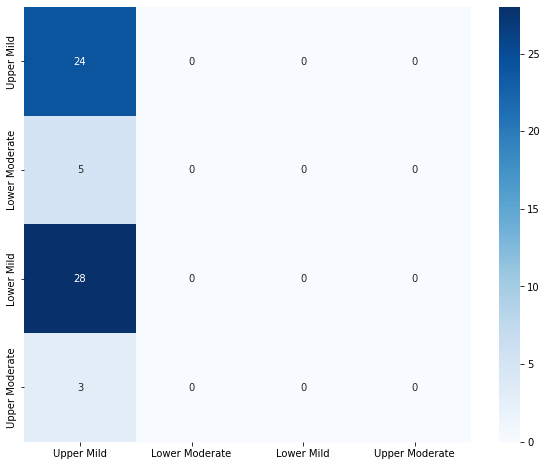

In [ ]:
labels = ['Upper Mild', 'Lower Moderate', 'Lower Mild','Upper Moderate']    

fig, ax = plt.subplots(figsize=(10,8))

cm = confusion_matrix(head_y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues)

ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels)
plt.show()

In [ ]:
head_rcnn = tf.keras.models.load_model(head_rcnn_model_path)
y_pred = head_rcnn.predict(head_X_test)
i = 0
for pred in y_pred:
    index = np.argmax(pred)
    tmp = np.array([0, 0, 0, 0])
    tmp[index] = 1
    y_pred[i] = tmp
    i += 1
y_pred = y_pred.astype(int)

In [ ]:
_, acc, auc, precision, recall, f1 = head_rcnn.evaluate(head_X_test, head_y_test, verbose=0)
bal_acc = balanced_accuracy_score(head_y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 43.33% 
Balanced Accuracy: 26.79% 
ROC/AUC: 0.54 
Precision: 0.33 
Recall: 0.03 
F1 score: 0.19


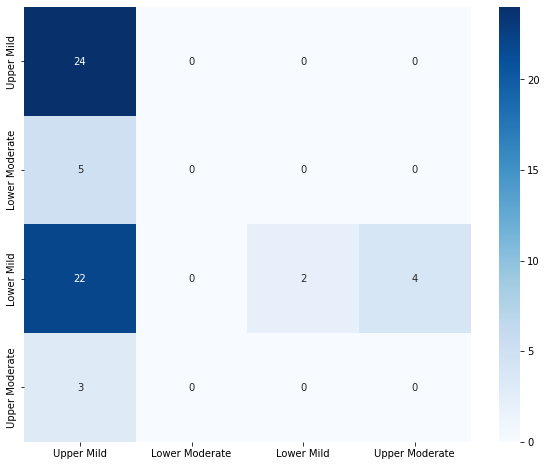

In [ ]:
labels = ['Upper Mild', 'Lower Moderate', 'Lower Mild','Upper Moderate']    

fig, ax = plt.subplots(figsize=(10,8))

cm = confusion_matrix(head_y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues)

ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels)
plt.show()

### Early Fusion (Feature Level)

In [ ]:
early_cnnlstm = tf.keras.models.load_model(early_cnnlstm_model_path)
y_pred = early_cnnlstm.predict(early_X_test)
i = 0
for pred in y_pred:
    index = np.argmax(pred)
    tmp = np.array([0, 0, 0, 0])
    tmp[index] = 1
    y_pred[i] = tmp
    i += 1
y_pred = y_pred.astype(int)

In [ ]:
_, acc, auc, precision, recall, f1 = early_cnnlstm.evaluate(early_X_test, early_y_test, verbose=0)
bal_acc = balanced_accuracy_score(early_y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 40.00% 
Balanced Accuracy: 25.00% 
ROC/AUC: 0.74 
Precision: 0.00 
Recall: 0.00 
F1 score: 0.14


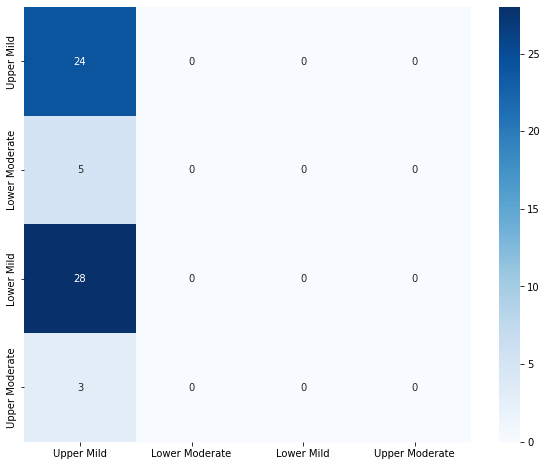

In [ ]:
labels = ['Upper Mild', 'Lower Moderate', 'Lower Mild','Upper Moderate']    

fig, ax = plt.subplots(figsize=(10,8))

cm = confusion_matrix(early_y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues)

ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels)
plt.show()

In [ ]:
early_convLSTM = tf.keras.models.load_model(early_convLSTM_model_path)
y_pred = early_convLSTM.predict(early_X_test)
i = 0
for pred in y_pred:
    index = np.argmax(pred)
    tmp = np.array([0, 0, 0, 0])
    tmp[index] = 1
    y_pred[i] = tmp
    i += 1
y_pred = y_pred.astype(int)

In [ ]:
_, acc, auc, precision, recall, f1 = early_convLSTM.evaluate(early_X_test, early_y_test, verbose=0)
bal_acc = balanced_accuracy_score(early_y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 40.00% 
Balanced Accuracy: 25.00% 
ROC/AUC: 0.74 
Precision: 0.00 
Recall: 0.00 
F1 score: 0.14


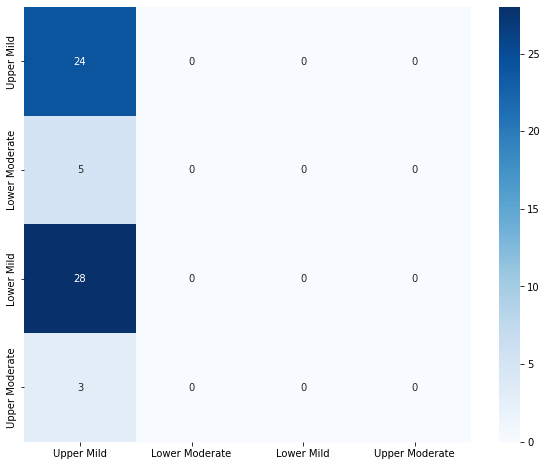

In [ ]:
labels = ['Upper Mild', 'Lower Moderate', 'Lower Mild','Upper Moderate']    

fig, ax = plt.subplots(figsize=(10,8))

cm = confusion_matrix(early_y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues)

ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels)
plt.show()

In [ ]:
early_rcnn = tf.keras.models.load_model(early_rcnn_model_path)
y_pred = early_rcnn.predict(early_X_test)
i = 0
for pred in y_pred:
    index = np.argmax(pred)
    tmp = np.array([0, 0, 0, 0])
    tmp[index] = 1
    y_pred[i] = tmp
    i += 1
y_pred = y_pred.astype(int)

In [ ]:
_, acc, auc, precision, recall, f1 = early_rcnn.evaluate(early_X_test, early_y_test, verbose=0)
bal_acc = balanced_accuracy_score(early_y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 36.67% 
Balanced Accuracy: 22.92% 
ROC/AUC: 0.63 
Precision: 0.00 
Recall: 0.00 
F1 score: 0.15


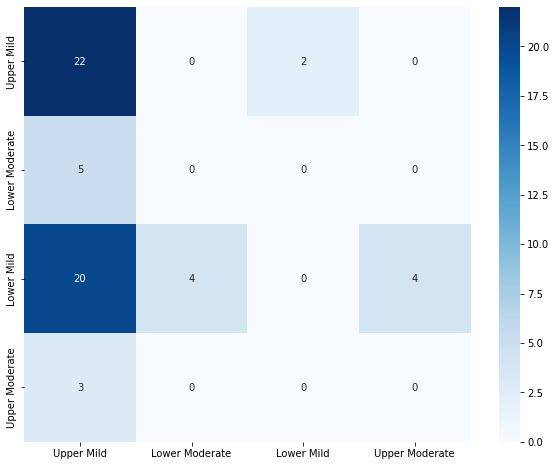

In [ ]:
labels = ['Upper Mild', 'Lower Moderate', 'Lower Mild','Upper Moderate']    

fig, ax = plt.subplots(figsize=(10,8))

cm = confusion_matrix(early_y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues)

ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels)
plt.show()

### Late Fusion (Decision Level)

In [ ]:
late_cnnlstm = tf.keras.models.load_model(late_cnnlstm_model_path)
y_pred = late_cnnlstm.predict([body_X_test, face_X_test, head_X_test])
i = 0
for pred in y_pred:
    index = np.argmax(pred)
    tmp = np.array([0, 0, 0, 0])
    tmp[index] = 1
    y_pred[i] = tmp
    i += 1
y_pred = y_pred.astype(int)

In [ ]:
_, acc, auc, precision, recall, f1 = late_cnnlstm.evaluate([body_X_test, face_X_test, head_X_test], y_test, verbose=0)
bal_acc = balanced_accuracy_score(early_y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 33.33% 
Balanced Accuracy: 28.75% 
ROC/AUC: 0.55 
Precision: 0.55 
Recall: 0.10 
F1 score: 0.18


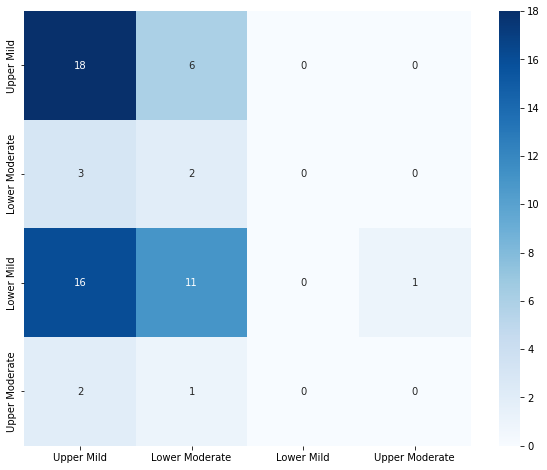

In [ ]:
labels = ['Upper Mild', 'Lower Moderate', 'Lower Mild','Upper Moderate']    

fig, ax = plt.subplots(figsize=(10,8))

cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues)

ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels)
plt.show()

In [ ]:
late_convlstm = tf.keras.models.load_model(late_convlstm_model_path)
y_pred = late_convlstm.predict([body_X_test, face_X_test, head_X_test])
i = 0
for pred in y_pred:
    index = np.argmax(pred)
    tmp = np.array([0, 0, 0, 0])
    tmp[index] = 1
    y_pred[i] = tmp
    i += 1
y_pred = y_pred.astype(int)

In [ ]:
_, acc, auc, precision, recall, f1 = late_convlstm.evaluate([body_X_test, face_X_test, head_X_test], y_test, verbose=0)
bal_acc = balanced_accuracy_score(early_y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 41.67% 
Balanced Accuracy: 29.70% 
ROC/AUC: 0.73 
Precision: 0.67 
Recall: 0.17 
F1 score: 0.23


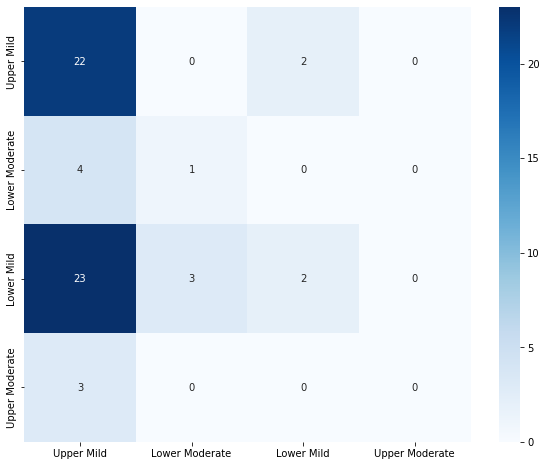

In [ ]:
labels = ['Upper Mild', 'Lower Moderate', 'Lower Mild','Upper Moderate']    

fig, ax = plt.subplots(figsize=(10,8))

cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues)

ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels)
plt.show()

In [ ]:
late_rcnn = tf.keras.models.load_model(late_rcnn_model_path)
y_pred = late_rcnn.predict([body_X_test, face_X_test, head_X_test])
i = 0
for pred in y_pred:
    index = np.argmax(pred)
    tmp = np.array([0, 0, 0, 0])
    tmp[index] = 1
    y_pred[i] = tmp
    i += 1
y_pred = y_pred.astype(int)

In [ ]:
_, acc, auc, precision, recall, f1 = late_rcnn.evaluate([body_X_test, face_X_test, head_X_test], y_test, verbose=0)
bal_acc = balanced_accuracy_score(early_y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 26.67% 
Balanced Accuracy: 20.62% 
ROC/AUC: 0.49 
Precision: 0.26 
Recall: 0.25 
F1 score: 0.15


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

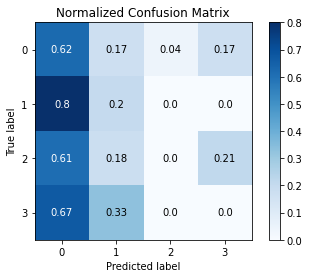

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True)

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

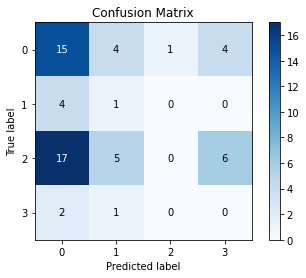

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

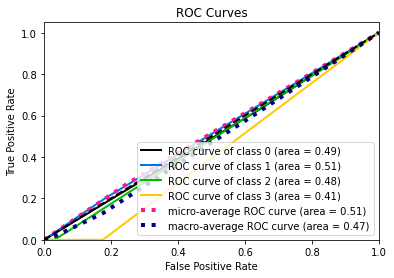

In [ ]:
skplt.metrics.plot_roc_curve(y_test.argmax(axis=1), y_pred)
plt.show()

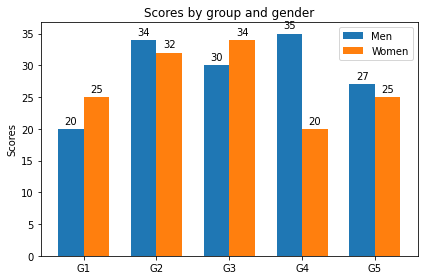

In [ ]:
labels = ['G1', 'G2', 'G3', 'G4', 'G5']
men_means = [20, 34, 30, 35, 27]
women_means = [25, 32, 34, 20, 25]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='Men')
rects2 = ax.bar(x + width/2, women_means, width, label='Women')

ax.set_ylabel('Scores') 
ax.set_title('Scores by group and gender')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [ ]:
print('Dirichlet Markov Ensemble:\n')
d = dirichletEnsemble.describe()

Dirichlet Markov Ensemble:

CNN+Bidirectional LSTM Body Model (weight: 0.0800)
CNN+Bidirectional LSTM Face Model (weight: 0.0528)
CNN+Bidirectional LSTM Head Model (weight: 0.0636)
ConvLSTM Body Model (weight: 0.2488)
ConvLSTM Face Model (weight: 0.1886)
ConvLSTM Head Model (weight: 0.0878)
RCNN Body Model (weight: 0.0006)
RCNN Face Model (weight: 0.2778)
RCNN Head Model (weight: 0.0000)

Accuracy: 46.67% 
Balanced Accuracy: 40.60% 
ROC/AUC: 0.64 
Precision: 0.61 
Recall: 0.41 
F1 score: 0.32
